# 1. Data Preprocessing

#### GPU Environment Setup

In [1]:
import os
import torch

# Configure and check GPU
print("GPU Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

# Install dependencies
!pip install -q pandas numpy scikit-learn tqdm
!pip install -q xgboost==2.0.3 catboost lightgbm==4.3.0 optuna
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu12
!pip install -q torch transformers sentence-transformers

GPU Available: True
GPU Name: Tesla T4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 40.7 MB/s eta 0:00:00


#### Data Loading

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')

# Define dataset paths
train_path = "/content/drive/MyDrive/BT4012_Project/data/fraudTrain.csv"
test_path = "/content/drive/MyDrive/BT4012_Project/data/fraudTest.csv"

# Loading datasets
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# Drop index column
train_df = train.drop(columns=["Unnamed: 0"], errors="ignore")
test_df = test.drop(columns=["Unnamed: 0"], errors="ignore")

# Print schema
train_df.info()

# Preview dataset
print("\nPreview:")
display(train_df.head())

# Row and column counts
print(f"\nNumber of rows: {train_df.shape[0]}")
print(f"Number of columns: {train_df.shape[1]}")

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0



Number of rows: 1296675
Number of columns: 22


#### Visualising Class Imbalance

- The dataset showed extreme class imbalance (fraud class is only 0.5% of the entire dataset).
- Class imbalance techniques such as class weighting and threshold tuning are required to ensure robust model performance.


Class distribution (counts):
is_fraud
0    1289169
1       7506
Name: count, dtype: int64

Class distribution (ratios):
is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64


/tmp/ipython-input-1968303300.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set1")


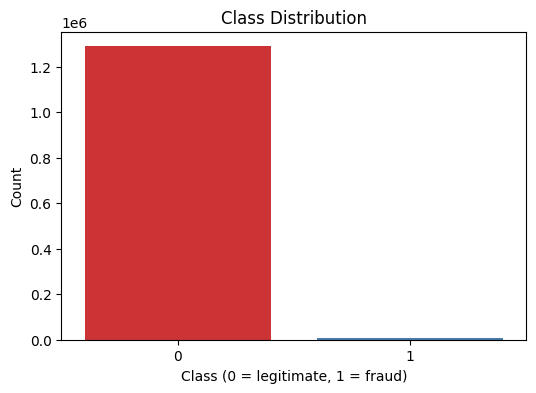

In [3]:
# Target Distribution
class_counts = train_df["is_fraud"].value_counts()
class_ratios = train_df["is_fraud"].value_counts(normalize=True)

print("Class distribution (counts):")
print(class_counts)

print("\nClass distribution (ratios):")
print(class_ratios)

# Visualize imbalance
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="Set1")
plt.title("Class Distribution")
plt.xlabel("Class (0 = legitimate, 1 = fraud)")
plt.ylabel("Count")
plt.show()

## 1.1. Data Cleaning

### 1.1.1. Check for missing values

In [4]:
# Function to check missing values
def check_missing_values(df, display=True):
    missing_dict = {}

    # Iterate through all columns
    for col_name in df.columns:

        if pd.api.types.is_numeric_dtype(df[col_name]):
            # Count NaN or None
            missing_count = df[col_name].isna().sum()
        else:
            # Count only None/NaN (strings cannot contain NaN unless explicitly inserted)
            missing_count = df[col_name].isna().sum()

        missing_dict[col_name] = int(missing_count)

    # Display logic
    if display:
        if all(v == 0 for v in missing_dict.values()):
            print("No missing values found.")
        else:
            print("Missing values detected:")
            display(pd.DataFrame([missing_dict]))

    return missing_dict


# Apply to both train and test
check_missing_values(train_df, display=True)
check_missing_values(test_df, display=False)


No missing values found.


{'trans_date_trans_time': 0,
 'cc_num': 0,
 'merchant': 0,
 'category': 0,
 'amt': 0,
 'first': 0,
 'last': 0,
 'gender': 0,
 'street': 0,
 'city': 0,
 'state': 0,
 'zip': 0,
 'lat': 0,
 'long': 0,
 'city_pop': 0,
 'job': 0,
 'dob': 0,
 'trans_num': 0,
 'unix_time': 0,
 'merch_lat': 0,
 'merch_long': 0,
 'is_fraud': 0}

### 1.1.2. Check for duplicate rows

In [5]:
# Function to check duplicate rows
def check_duplicates(df, display=True):

    # Count full-row duplicates
    duplicate_mask = df.duplicated(keep=False)  # count all duplicates
    duplicates_df = df[duplicate_mask]

    if not display:
        return None

    if duplicates_df.empty:
        print("No duplicate rows found.")
        return
    # Count number of duplicate groups (Spark counted grouped rows)
    num_duplicate_rows = duplicates_df.shape[0]
    print(f"{num_duplicate_rows} duplicate rows detected:")
    display(duplicates_df.drop_duplicates())


# Apply to both train and test
check_duplicates(train_df, display=True)
check_duplicates(test_df, display=False)


No duplicate rows found.


## 1.2. Remove high cardinality features

Most of these columns are identifiers with very high cardinality and adds a lot of unecessary noise at the expense of predictive power
- trans_num is an identifier, first and last name can be captured more accurately with cc_num
- zip and street are highly correlated with lat/long

In [6]:
# Function to drop high cardinality features
def drop_hc_features(df, display=False):
    # Define columns to drop
    columns_to_drop = ["zip", "trans_num", "first", "last", "street"]
    # Drop specified columns
    df = df.drop(columns=columns_to_drop, errors="ignore")

    # Display results
    if display:
        print(f"Number of rows: {df.shape[0]}")
        print(f"Number of columns: {df.shape[1]}\n")
        print(df.info())

    return df


# Apply to both train and test
train_df = drop_hc_features(train_df, display=True)
test_df = drop_hc_features(test_df, display=False)


Number of rows: 1296675
Number of columns: 17

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   gender                 1296675 non-null  object 
 6   city                   1296675 non-null  object 
 7   state                  1296675 non-null  object 
 8   lat                    1296675 non-null  float64
 9   long                   1296675 non-null  float64
 10  city_pop               1296675 non-null  int64  
 11  job                    1296675 non-null  object 
 12  dob                    1296675 non-null  object 
 13  unix_time              12

# 2. Feature Engineering

## 2.1. Domain Knowledge-based Feature Creation

### City and State level features

- city_fraud_rate
- city_txn_count
- state_fraud_rate
- state_txn_count

These features capture location-level fraud risk patterns and transaction density. They help the model identify geographic regions with historically higher fraud likelihood while weighting cities or states with more reliable transaction volumes more heavily.

In [7]:
# Function to engineer city and state transaction features
def add_city_and_state_features(train_df, test_df, label_col="is_fraud"):

    # Compute city and state level statistics on train set
    city_stats = train_df.groupby("city")[label_col].agg(
        # City fraud rate
        city_fraud_rate="mean",
        # City transaction count
        city_txn_count="count"
    ).reset_index()

    state_stats = train_df.groupby("state")[label_col].agg(
        # State fraud rate
        state_fraud_rate="mean",
        # State transaction count
        state_txn_count="count"
    ).reset_index()

    # Join stats to both datasets
    train_df = train_df.merge(city_stats, on="city", how="left")
    train_df = train_df.merge(state_stats, on="state", how="left")
    test_df = test_df.merge(city_stats, on="city", how="left")
    test_df = test_df.merge(state_stats, on="state", how="left")

    # Fill new unseen cities in test sets with 0
    test_df[["city_fraud_rate", "city_txn_count",
             "state_fraud_rate", "state_txn_count"]] = (
        test_df[["city_fraud_rate", "city_txn_count",
                 "state_fraud_rate", "state_txn_count"]]
        .fillna({"city_fraud_rate": 0.0,
                 "city_txn_count": 0,
                 "state_fraud_rate": 0.0,
                 "state_txn_count": 0})
    )

    # Display train set only
    print("Train set after adding city/state fraud features:\n")
    print(train_df.head(5).to_string(index=False))
    print(f"\nNumber of rows: {train_df.shape[0]}")
    print(f"Number of columns: {train_df.shape[1]}\n")

    return train_df, test_df


# Fit on train and transform on test (avoid data leakage)
train_df, test_df = add_city_and_state_features(train_df, test_df)

Train set after adding city/state fraud features:

trans_date_trans_time           cc_num                           merchant      category    amt gender           city state     lat      long  city_pop                               job        dob  unix_time  merch_lat  merch_long  is_fraud  city_fraud_rate  city_txn_count  state_fraud_rate  state_txn_count
  2019-01-01 00:00:18 2703186189652095         fraud_Rippin, Kub and Mann      misc_net   4.97      F Moravian Falls    NC 36.0788  -81.1781      3495         Psychologist, counselling 1988-03-09 1325376018  36.011293  -82.048315         0         0.000000            2028          0.004923            30266
  2019-01-01 00:00:44     630423337322    fraud_Heller, Gutmann and Zieme   grocery_pos 107.23      F         Orient    WA 48.8878 -118.2105       149 Special educational needs teacher 1978-06-21 1325376044  49.159047 -118.186462         0         0.000000            3545          0.005073            18924
  2019-01-01 00:00:51   3

### Transactions in last hour (Burstiness)

Captures short-term transaction frequency patterns; a sudden burst of transactions within a short time window often signals automated or fraudulent spending behavior.

In [8]:
# Function to engineer burstiness feature (transactions in last hour)
def add_burstiness(df, display=True):
    # Sort by cc_num, then by time
    df = df.sort_values(["cc_num", "unix_time"]).reset_index(drop=True)

    # Pre-allocate array
    counts = np.zeros(len(df), dtype=int)

    # Create groupby object
    grouped = df.groupby("cc_num")

    # Compute sliding-window burstiness
    for cc, group in grouped:
        times = group["unix_time"].values
        n = len(times)

        left = 0
        for right in range(n):
            # Move left pointer until window is within 3600 seconds
            while times[right] - times[left] > 3600:
                left += 1
            # Count window size
            counts[group.index[right]] = right - left + 1

    # Assign feature
    df["transactions_in_last_hour"] = counts

    # Restore original chronological order
    df = df.sort_values("unix_time").reset_index(drop=True)

    # Display results
    if display:
        print("Train set after adding 'transactions_in_last_hour':\n")
        print(df.head(5).to_string(index=False))
        print(f"\nNumber of rows: {df.shape[0]}")
        print(f"Number of columns: {df.shape[1]}\n")

    return df


# Apply to both train and test
train_df = add_burstiness(train_df, display=True)
test_df = add_burstiness(test_df, display=False)

Train set after adding 'transactions_in_last_hour':

trans_date_trans_time           cc_num                           merchant      category    amt gender           city state     lat      long  city_pop                               job        dob  unix_time  merch_lat  merch_long  is_fraud  city_fraud_rate  city_txn_count  state_fraud_rate  state_txn_count  transactions_in_last_hour
  2019-01-01 00:00:18 2703186189652095         fraud_Rippin, Kub and Mann      misc_net   4.97      F Moravian Falls    NC 36.0788  -81.1781      3495         Psychologist, counselling 1988-03-09 1325376018  36.011293  -82.048315         0         0.000000            2028          0.004923            30266                          1
  2019-01-01 00:00:44     630423337322    fraud_Heller, Gutmann and Zieme   grocery_pos 107.23      F         Orient    WA 48.8878 -118.2105       149 Special educational needs teacher 1978-06-21 1325376044  49.159047 -118.186462         0         0.000000            3545     

### Geographic distance between home & merchant (Haversine Distance)

Measures the spatial deviation between a customer’s usual location and the merchant’s location; unusually large distances may indicate card theft or unauthorized remote usage.

In [9]:
# Function to engineer harversine distance feature (geographic distance between home and merchant)
def add_harvesine_distance(df, display=True):
    R = 6371.0  # Earth's radius in km

    # Convert degrees to radians
    lat_rad = np.radians(df["lat"])
    lon_rad = np.radians(df["long"])
    merch_lat_rad = np.radians(df["merch_lat"])
    merch_lon_rad = np.radians(df["merch_long"])

    # Compute deltas
    dlat = merch_lat_rad - lat_rad
    dlon = merch_lon_rad - lon_rad

    # Apply Haversine formula
    a = (
        np.sin(dlat / 2) ** 2 +
        np.cos(lat_rad) * np.cos(merch_lat_rad) * np.sin(dlon / 2) ** 2
    )

    c = 2 * np.arcsin(np.sqrt(a))

    # Final distance
    df["geo_distance_from_home"] = R * c

    # Display results
    if display:
        print("Train set after adding 'geo_distance_from_home':\n")
        print(df.head(5).to_string(index=False))
        print(f"\nNumber of rows: {df.shape[0]}")
        print(f"Number of columns: {df.shape[1]}\n")

    return df


# Apply to both train and test
train_df = add_harvesine_distance(train_df, display=True)
test_df  = add_harvesine_distance(test_df, display=False)


Train set after adding 'geo_distance_from_home':

trans_date_trans_time           cc_num                           merchant      category    amt gender           city state     lat      long  city_pop                               job        dob  unix_time  merch_lat  merch_long  is_fraud  city_fraud_rate  city_txn_count  state_fraud_rate  state_txn_count  transactions_in_last_hour  geo_distance_from_home
  2019-01-01 00:00:18 2703186189652095         fraud_Rippin, Kub and Mann      misc_net   4.97      F Moravian Falls    NC 36.0788  -81.1781      3495         Psychologist, counselling 1988-03-09 1325376018  36.011293  -82.048315         0         0.000000            2028          0.004923            30266                          1               78.597568
  2019-01-01 00:00:44     630423337322    fraud_Heller, Gutmann and Zieme   grocery_pos 107.23      F         Orient    WA 48.8878 -118.2105       149 Special educational needs teacher 1978-06-21 1325376044  49.159047 -118.186462   

### Timestamp-based features

Extracts the hour and weekday of transactions to detect temporal fraud patterns, such as purchases made at unusual hours or on specific days when legitimate activity is rare.

In [10]:
# Function to engineer timestamp features
def add_timestamp_features(df, display=True):
    # Ensure datetime dtype
    df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])

    # Extract timestamp features
    df["trans_year"] = df["trans_date_trans_time"].dt.year
    df["trans_month"] = df["trans_date_trans_time"].dt.month
    df["trans_day"] = df["trans_date_trans_time"].dt.day
    df["trans_hour"] = df["trans_date_trans_time"].dt.hour

    # Spark weekday: 1=Sunday … 7=Saturday
    df["trans_weekday"] = df["trans_date_trans_time"].dt.weekday + 1
    # pandas weekday: Monday=0 … Sunday=6 → +1 aligns to Spark except Sunday maps to 7

    # Weekend: Spark uses Sunday (1) and Saturday (7)
    df["is_weekend"] = df["trans_weekday"].isin([1, 7]).astype(int)

    if display:
        print("Train set after adding timestamp-based features:\n")
        print(df.head(5).to_string(index=False))
        print(f"\nNumber of rows: {df.shape[0]}")
        print(f"Number of columns: {df.shape[1]}\n")

    return df


# Apply to both train and test
train_df = add_timestamp_features(train_df, display=True)
test_df = add_timestamp_features(test_df, display=False)

Train set after adding timestamp-based features:

trans_date_trans_time           cc_num                           merchant      category    amt gender           city state     lat      long  city_pop                               job        dob  unix_time  merch_lat  merch_long  is_fraud  city_fraud_rate  city_txn_count  state_fraud_rate  state_txn_count  transactions_in_last_hour  geo_distance_from_home  trans_year  trans_month  trans_day  trans_hour  trans_weekday  is_weekend
  2019-01-01 00:00:18 2703186189652095         fraud_Rippin, Kub and Mann      misc_net   4.97      F Moravian Falls    NC 36.0788  -81.1781      3495         Psychologist, counselling 1988-03-09 1325376018  36.011293  -82.048315         0         0.000000            2028          0.004923            30266                          1               78.597568        2019            1          1           0              2           0
  2019-01-01 00:00:44     630423337322    fraud_Heller, Gutmann and Zieme   grocer

### Age of the Customer at time of transaction

Provides demographic context for transaction behavior; different age groups exhibit distinct spending habits and risk profiles, enabling the model to identify out-of-pattern activity for that age range.

In [11]:
# Function to engineer and compute age of customer at the time of transaction
def add_age_at_transaction(df, display=True):
    # Ensure datetime types
    df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
    df["dob"] = pd.to_datetime(df["dob"])

    # Calculate customer's age
    df["age_at_transaction"] = np.floor(
        (df["trans_date_trans_time"] - df["dob"]).dt.days / 365.25
    ).astype(int)

    # Display results
    if display:
        print("Train set after adding 'age_at_transaction':\n")
        print(df.head(5).to_string(index=False))
        print(f"\nNumber of rows: {df.shape[0]}")
        print(f"Number of columns: {df.shape[1]}\n")

    return df


# Apply to both train and test
train_df = add_age_at_transaction(train_df, display=True)
test_df = add_age_at_transaction(test_df, display=False)

Train set after adding 'age_at_transaction':

trans_date_trans_time           cc_num                           merchant      category    amt gender           city state     lat      long  city_pop                               job        dob  unix_time  merch_lat  merch_long  is_fraud  city_fraud_rate  city_txn_count  state_fraud_rate  state_txn_count  transactions_in_last_hour  geo_distance_from_home  trans_year  trans_month  trans_day  trans_hour  trans_weekday  is_weekend  age_at_transaction
  2019-01-01 00:00:18 2703186189652095         fraud_Rippin, Kub and Mann      misc_net   4.97      F Moravian Falls    NC 36.0788  -81.1781      3495         Psychologist, counselling 1988-03-09 1325376018  36.011293  -82.048315         0         0.000000            2028          0.004923            30266                          1               78.597568        2019            1          1           0              2           0                  30
  2019-01-01 00:00:44     630423337322    frau

### Drop features after engineering

In [12]:
# Function to drop features after derived features are created from them after feature engineering
def drop_features(df, display=True):
    # Define columns to drop
    columns_to_drop = ["trans_date_trans_time", "cc_num", "merchant", "city",
                       "lat", "long", "job", "dob", "unix_time", "merch_lat", "merch_long"]

    # Drop specified columns that exist
    existing_cols = [c for c in columns_to_drop if c in df.columns]
    df = df.drop(columns=existing_cols)

    # Display results
    if display:
        print("Train set after dropping columns:\n")
        print(df.head(5).to_string(index=False))
        print(f"\nNumber of rows: {df.shape[0]}")
        print(f"Number of columns: {df.shape[1]}\n")

    return df


# Apply to both train and test
train_df = drop_features(train_df, display=True)
test_df = drop_features(test_df, display=False)

Train set after dropping columns:

     category    amt gender state  city_pop  is_fraud  city_fraud_rate  city_txn_count  state_fraud_rate  state_txn_count  transactions_in_last_hour  geo_distance_from_home  trans_year  trans_month  trans_day  trans_hour  trans_weekday  is_weekend  age_at_transaction
     misc_net   4.97      F    NC      3495         0         0.000000            2028          0.004923            30266                          1               78.597568        2019            1          1           0              2           0                  30
  grocery_pos 107.23      F    WA       149         0         0.000000            3545          0.005073            18924                          1               30.212176        2019            1          1           0              2           0                  40
entertainment 220.11      M    ID      4154         0         0.000000             503          0.001984             5545                          1             

## 2.2. Categorical Encoding

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Function for categorical encoding
def encode_categorical_features(train_df, test_df, display=True):

    categorical_cols = ["state", "category"]
    binary_col = "gender"

    # Binary encode gender
    train_df["gender_binary"] = (train_df[binary_col] == "m").astype(int)
    test_df["gender_binary"]  = (test_df[binary_col] == "m").astype(int)

    # Label Encoding
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        train_df[col + "_idx"] = le.fit_transform(train_df[col])

        # Safe unseen handling for test set
        test_df[col + "_idx"] = test_df[col].map(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )

        label_encoders[col] = le

    # One Hot Encoding
    ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

    ohe_train = ohe.fit_transform(train_df[[c + "_idx" for c in categorical_cols]])
    ohe_test  = ohe.transform(test_df[[c + "_idx" for c in categorical_cols]])

    # Generate OHE column names
    ohe_feature_names = []
    for col in categorical_cols:
        num_categories = len(label_encoders[col].classes_)
        ohe_feature_names += [f"{col}_ohe_{k}" for k in range(num_categories)]

    # Convert OHE to dataframes
    train_ohe_df = pd.DataFrame(ohe_train, columns=ohe_feature_names, index=train_df.index)
    test_ohe_df  = pd.DataFrame(ohe_test,  columns=ohe_feature_names, index=test_df.index)

    # Add encoded features
    train_df = pd.concat([train_df, train_ohe_df], axis=1)
    test_df  = pd.concat([test_df,  test_ohe_df], axis=1)

    # Drop original columns
    drop_cols = ["state", "category", "gender"]
    train_df = train_df.drop(columns=[c for c in drop_cols if c in train_df.columns])
    test_df  = test_df.drop(columns=[c for c in drop_cols if c in test_df.columns])

    # Display results
    if display:
        print("Train set after categorical encoding:\n")
        print(train_df.head(5).to_string(index=False))
        print(f"\nNumber of rows: {train_df.shape[0]}")
        print(f"Number of columns: {train_df.shape[1]}\n")

    return train_df, test_df


# Fit on train and transform on test (avoid data leakage)
train_df, test_df = encode_categorical_features(train_df, test_df, display=True)


Train set after categorical encoding:

   amt  city_pop  is_fraud  city_fraud_rate  city_txn_count  state_fraud_rate  state_txn_count  transactions_in_last_hour  geo_distance_from_home  trans_year  trans_month  trans_day  trans_hour  trans_weekday  is_weekend  age_at_transaction  gender_binary  state_idx  category_idx  state_ohe_0  state_ohe_1  state_ohe_2  state_ohe_3  state_ohe_4  state_ohe_5  state_ohe_6  state_ohe_7  state_ohe_8  state_ohe_9  state_ohe_10  state_ohe_11  state_ohe_12  state_ohe_13  state_ohe_14  state_ohe_15  state_ohe_16  state_ohe_17  state_ohe_18  state_ohe_19  state_ohe_20  state_ohe_21  state_ohe_22  state_ohe_23  state_ohe_24  state_ohe_25  state_ohe_26  state_ohe_27  state_ohe_28  state_ohe_29  state_ohe_30  state_ohe_31  state_ohe_32  state_ohe_33  state_ohe_34  state_ohe_35  state_ohe_36  state_ohe_37  state_ohe_38  state_ohe_39  state_ohe_40  state_ohe_41  state_ohe_42  state_ohe_43  state_ohe_44  state_ohe_45  state_ohe_46  state_ohe_47  state_ohe_48  sta

## 2.3. Train-Validation Split

In [13]:
from sklearn.model_selection import train_test_split

# Function to perform train-validation split on train set only
def split_train_val(df, target_col="is_fraud", test_size=0.2, random_state=42):
    # Split features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Perform stratified train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    # Extract test target
    y_test = test_df["is_fraud"]
    X_test = test_df.drop(columns=["is_fraud"])

    # Display results
    print(f"X_train: {X_train.shape[0]:,} rows × {X_train.shape[1]} columns")
    print(f"X_val: {X_val.shape[0]:,} rows × {X_val.shape[1]} columns")
    print("\nClass distribution (train):")
    print(y_train.value_counts(normalize=True))
    print("\nClass distribution (val):")
    print(y_val.value_counts(normalize=True))

    return X_train, X_val, X_test, y_train, y_val, y_test


# Only apply to train
X_train, X_val, X_test, y_train, y_val, y_test = split_train_val(train_df)

X_train: 1,037,340 rows × 83 columns
X_val: 259,335 rows × 83 columns

Class distribution (train):
is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64

Class distribution (val):
is_fraud
0    0.994212
1    0.005788
Name: proportion, dtype: float64


## 2.4. Feature Scaling

In [14]:
from sklearn.preprocessing import StandardScaler

# Function to perform feature scaling
def scale_features(X_train, X_val, X_test, exclude_cols=None, display=True):
    if exclude_cols is None:
        exclude_cols = []

    # Identify numeric columns
    numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # Exclude integer-coded categoricals and OHE columns
    numeric_cols = [c for c in numeric_cols if c not in exclude_cols]
    ohe_cols = [c for c in X_train.columns if c.startswith("state_ohe_") or c.startswith("category_ohe_")]
    numeric_cols = [c for c in numeric_cols if c not in ohe_cols]

    print("\nNumeric columns being scaled:")
    print(numeric_cols)

    # Copy datasets
    X_train_scaled = X_train.copy()
    X_val_scaled   = X_val.copy()
    X_test_scaled  = X_test.copy()

    # Fit scaler on train set only
    scaler = StandardScaler()
    X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

    # Transform on val and test
    X_val_scaled[numeric_cols]  = scaler.transform(X_val[numeric_cols])
    X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

    # Display results
    if display:
        print("\nTrain set after feature scaling:\n")
        print(X_train_scaled.head(5).to_string(index=False))
        print(f"\nNumber of rows: {X_train_scaled.shape[0]}")
        print(f"Number of columns: {X_train_scaled.shape[1]}\n")

    return X_train_scaled, X_val_scaled, X_test_scaled, scaler


# Fit on train and transform on val and test (avoid data leakage)
exclude_cols = ["state_idx", "category_idx"]
X_train_scaled, X_val_scaled, X_test_scaled, scaler = scale_features(
    X_train, X_val, X_test, exclude_cols=exclude_cols
)


Numeric columns being scaled:
['amt', 'city_fraud_rate', 'state_fraud_rate', 'geo_distance_from_home']

Train set after feature scaling:

      amt  city_pop  city_fraud_rate  city_txn_count  state_fraud_rate  state_txn_count  transactions_in_last_hour  geo_distance_from_home  trans_year  trans_month  trans_day  trans_hour  trans_weekday  is_weekend  age_at_transaction  gender_binary  state_idx  category_idx  state_ohe_0  state_ohe_1  state_ohe_2  state_ohe_3  state_ohe_4  state_ohe_5  state_ohe_6  state_ohe_7  state_ohe_8  state_ohe_9  state_ohe_10  state_ohe_11  state_ohe_12  state_ohe_13  state_ohe_14  state_ohe_15  state_ohe_16  state_ohe_17  state_ohe_18  state_ohe_19  state_ohe_20  state_ohe_21  state_ohe_22  state_ohe_23  state_ohe_24  state_ohe_25  state_ohe_26  state_ohe_27  state_ohe_28  state_ohe_29  state_ohe_30  state_ohe_31  state_ohe_32  state_ohe_33  state_ohe_34  state_ohe_35  state_ohe_36  state_ohe_37  state_ohe_38  state_ohe_39  state_ohe_40  state_ohe_41  state_oh

# 3. Feature Selection

In [15]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# Function to perform feature selection
def select_features(X_train_scaled, y_train, X_val_scaled, X_test_scaled, threshold="median", display=True):

    # Fit ExtraTrees classifier on X_train
    et_model = ExtraTreesClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    )
    et_model.fit(X_train_scaled, y_train)

    # Use median importance metric to select features
    importances = et_model.feature_importances_
    # Keep features ABOVE median importance
    threshold_value = np.median(importances)
    mask = importances >= threshold_value

    # Consistent feature names
    kept_feature_names = X_train_scaled.columns[mask].tolist()

    # Subset manually
    X_train_sel = X_train_scaled[kept_feature_names]
    X_val_sel = X_val_scaled[kept_feature_names]
    X_test_sel = X_test_scaled[kept_feature_names]

    # Display summary
    if display:
        print("===== Feature Selection Summary =====\n")
        print(f"Total original features: {X_train_scaled.shape[1]}")
        print(f"Features retained: {len(kept_feature_names)}")
        print(f"Features removed: {X_train_scaled.shape[1] - len(kept_feature_names)}\n")

        print("Selected Features:")
        print(", ".join(kept_feature_names))

        print("\nPreview of X_train after feature selection:")
        print(X_train_sel.head().to_string())

    return X_train_sel, X_val_sel, X_test_sel, kept_feature_names, et_model


# Fit on train and transform on val and test (avoid data leakage)
X_train_sel, X_val_sel, X_test_sel, kept_features, et_model = select_features(
    X_train_scaled,
    y_train,
    X_val_scaled,
    X_test_scaled,
    threshold="median",
    display=True
)


===== Feature Selection Summary =====

Total original features: 83
Features retained: 42
Features removed: 41

Selected Features:
amt, city_pop, city_fraud_rate, city_txn_count, state_fraud_rate, state_txn_count, transactions_in_last_hour, geo_distance_from_home, trans_year, trans_month, trans_day, trans_hour, trans_weekday, is_weekend, age_at_transaction, state_idx, category_idx, state_ohe_1, state_ohe_2, state_ohe_4, state_ohe_9, state_ohe_14, state_ohe_22, state_ohe_24, state_ohe_34, state_ohe_35, state_ohe_38, state_ohe_40, state_ohe_43, category_ohe_0, category_ohe_1, category_ohe_2, category_ohe_3, category_ohe_4, category_ohe_5, category_ohe_6, category_ohe_7, category_ohe_8, category_ohe_9, category_ohe_10, category_ohe_11, category_ohe_12

Preview of X_train after feature selection:
             amt  city_pop  city_fraud_rate  city_txn_count  state_fraud_rate  state_txn_count  transactions_in_last_hour  geo_distance_from_home  trans_year  trans_month  trans_day  trans_hour  tr

# 4. Model Training + Hyperparameter Tuning

#### Importing Libraries + Drive Mount

In [17]:
# Import libraries
import joblib
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    precision_recall_fscore_support,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)

import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Mount drive
drive.mount('/content/drive')

# Check GPU device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Output directory
out_dir = "/content/drive/MyDrive/BT4012_Project/models"
os.makedirs(out_dir, exist_ok=True)
print("Models will be saved to:", out_dir)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Models will be saved to: /content/drive/MyDrive/BT4012_Project/models


#### Class Imbalance Weights

In [18]:
# Class imbalance weighting
num_pos = (y_train == 1).sum()
num_neg = (y_train == 0).sum()
scale_pos_weight = num_neg / num_pos
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 171.74604496253122


#### Optuna Output Formatting

In [19]:
# Function to format trial outputs
def optuna_callback(study, trial):
    print(f"Trial {trial.number:02d} | PR-AUC = {trial.value:.6f}")

#### Evaluation Helper (for both validation and test set)

In [20]:
# Function to compute evaluation metrics for validation AND test sets
def evaluate_model(name, y_true, y_pred_proba, threshold=0.5):
    pr_auc = average_precision_score(y_true, y_pred_proba)
    roc = roc_auc_score(y_true, y_pred_proba)
    y_pred = (y_pred_proba >= threshold).astype(int)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )

    print(f"\n===== {name} Evaluation =====")
    print(f"PR-AUC:   {pr_auc:.6f}")
    print(f"ROC-AUC:  {roc:.6f}")
    print(f"Precision:{precision:.6f}")
    print(f"Recall:   {recall:.6f}")
    print(f"F1:       {f1:.6f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=6, zero_division=0))

    return pr_auc

## 4.1 Base Models



### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
import joblib

# Define param grid for Optuna tuning
def objective_lr(trial):
    C = trial.suggest_float("C", 1e-3, 10.0, log=True)

    model = LogisticRegression(
        C=C,
        class_weight="balanced",
        max_iter=1000,
        solver="lbfgs",
        n_jobs=-1
    )

    model.fit(X_train_sel, y_train)
    val_pred = model.predict_proba(X_val_sel)[:, 1]

    prauc = average_precision_score(y_val, val_pred)

    return prauc


# Train and tune logistic regression
def train_tune_lr():
    print("\nTuning Logistic Regression with Optuna...")
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_lr, n_trials=20, callbacks=[optuna_callback])
    print("\nBest LR Params:", study.best_params)
    print("Best LR PR-AUC:", study.best_value)

    # Train final model
    best_params = study.best_params
    final_lr = LogisticRegression(
        C=best_params["C"],
        class_weight="balanced",
        max_iter=1000,
        solver="lbfgs",
        n_jobs=-1
    )

    final_lr.fit(X_train_sel, y_train)

    # Validation evaluation
    val_pred = final_lr.predict_proba(X_val_sel)[:, 1]
    evaluate_model("Logistic Regression (tuned)", y_val, val_pred)

    # Save train and tuned model
    joblib.dump(final_lr, f"{out_dir}/logreg.pkl")
    print("Saved LR model")

    return final_lr


# Train and tune LR
lr_model = train_tune_lr()

[I 2025-11-16 23:08:16,019] A new study created in memory with name: no-name-9d7401b8-cda1-46bd-ac82-026403cfbe72



Tuning Logistic Regression with Optuna...


[I 2025-11-16 23:10:44,140] Trial 0 finished with value: 0.27628407166990865 and parameters: {'C': 0.005520488088946373}. Best is trial 0 with value: 0.27628407166990865.


Trial 00 | PR-AUC = 0.276284


[I 2025-11-16 23:13:13,205] Trial 1 finished with value: 0.24329160504169367 and parameters: {'C': 0.0017453800200352436}. Best is trial 0 with value: 0.27628407166990865.


Trial 01 | PR-AUC = 0.243292


[I 2025-11-16 23:15:44,552] Trial 2 finished with value: 0.24149474372985003 and parameters: {'C': 7.956244604204331}. Best is trial 0 with value: 0.27628407166990865.


Trial 02 | PR-AUC = 0.241495


[I 2025-11-16 23:18:19,870] Trial 3 finished with value: 0.2811567199149927 and parameters: {'C': 1.8099359013803862}. Best is trial 3 with value: 0.2811567199149927.


Trial 03 | PR-AUC = 0.281157


[I 2025-11-16 23:20:49,621] Trial 4 finished with value: 0.250206388608104 and parameters: {'C': 0.6605686542498507}. Best is trial 3 with value: 0.2811567199149927.


Trial 04 | PR-AUC = 0.250206


[I 2025-11-16 23:23:21,526] Trial 5 finished with value: 0.24496205645217045 and parameters: {'C': 9.1285797834873}. Best is trial 3 with value: 0.2811567199149927.


Trial 05 | PR-AUC = 0.244962


[I 2025-11-16 23:25:54,165] Trial 6 finished with value: 0.2450965793312735 and parameters: {'C': 3.0990114501015964}. Best is trial 3 with value: 0.2811567199149927.


Trial 06 | PR-AUC = 0.245097


[I 2025-11-16 23:28:28,547] Trial 7 finished with value: 0.24812290763763253 and parameters: {'C': 5.2509066123619546}. Best is trial 3 with value: 0.2811567199149927.


Trial 07 | PR-AUC = 0.248123


[I 2025-11-16 23:31:00,127] Trial 8 finished with value: 0.31295794345306527 and parameters: {'C': 6.104973659305208}. Best is trial 8 with value: 0.31295794345306527.


Trial 08 | PR-AUC = 0.312958


[I 2025-11-16 23:33:34,437] Trial 9 finished with value: 0.25435060063032117 and parameters: {'C': 0.5392993544432665}. Best is trial 8 with value: 0.31295794345306527.


Trial 09 | PR-AUC = 0.254351


[I 2025-11-16 23:36:07,702] Trial 10 finished with value: 0.30760802410575333 and parameters: {'C': 0.10030644236434018}. Best is trial 8 with value: 0.31295794345306527.


Trial 10 | PR-AUC = 0.307608


[I 2025-11-16 23:38:41,044] Trial 11 finished with value: 0.24429715355399456 and parameters: {'C': 0.06096720935803314}. Best is trial 8 with value: 0.31295794345306527.


Trial 11 | PR-AUC = 0.244297


[I 2025-11-16 23:41:14,099] Trial 12 finished with value: 0.24420468094386594 and parameters: {'C': 0.05755197039529563}. Best is trial 8 with value: 0.31295794345306527.


Trial 12 | PR-AUC = 0.244205


[I 2025-11-16 23:43:50,688] Trial 13 finished with value: 0.3073030385935965 and parameters: {'C': 0.0198286970071809}. Best is trial 8 with value: 0.31295794345306527.


Trial 13 | PR-AUC = 0.307303


[I 2025-11-16 23:46:25,957] Trial 14 finished with value: 0.30732067898638354 and parameters: {'C': 0.3072945321135976}. Best is trial 8 with value: 0.31295794345306527.


Trial 14 | PR-AUC = 0.307321


[I 2025-11-16 23:48:59,386] Trial 15 finished with value: 0.2949128262877966 and parameters: {'C': 0.17332391476258777}. Best is trial 8 with value: 0.31295794345306527.


Trial 15 | PR-AUC = 0.294913


[I 2025-11-16 23:51:33,901] Trial 16 finished with value: 0.30110917022592093 and parameters: {'C': 0.015435826920307592}. Best is trial 8 with value: 0.31295794345306527.


Trial 16 | PR-AUC = 0.301109


[I 2025-11-16 23:54:07,456] Trial 17 finished with value: 0.2509735034037556 and parameters: {'C': 1.2692751114569725}. Best is trial 8 with value: 0.31295794345306527.


Trial 17 | PR-AUC = 0.250974


[I 2025-11-16 23:56:38,835] Trial 18 finished with value: 0.26847193438325184 and parameters: {'C': 0.02149810203227695}. Best is trial 8 with value: 0.31295794345306527.


Trial 18 | PR-AUC = 0.268472


[I 2025-11-16 23:59:11,945] Trial 19 finished with value: 0.287327504628179 and parameters: {'C': 0.0011597035921876368}. Best is trial 8 with value: 0.31295794345306527.


Trial 19 | PR-AUC = 0.287328

Best LR Params: {'C': 6.104973659305208}
Best LR PR-AUC: 0.31295794345306527

===== Logistic Regression (tuned) Evaluation =====
PR-AUC:   0.312958
ROC-AUC:  0.898838
Precision:0.054373
Recall:   0.796136
F1:       0.101793

Classification Report:
              precision    recall  f1-score   support

           0   0.998711  0.919394  0.957412    257834
           1   0.054373  0.796136  0.101793      1501

    accuracy                       0.918680    259335
   macro avg   0.526542  0.857765  0.529603    259335
weighted avg   0.993245  0.918680  0.952460    259335

Saved LR model


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import joblib

# Define param grid for Optuna tuning
def objective_rf(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 600),
        "max_depth": trial.suggest_int("max_depth", 6, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "class_weight": "balanced",
        "n_jobs": -1,
        "random_state": 42
    }

    model = RandomForestClassifier(**params)
    model.fit(X_train_sel, y_train)

    val_pred = model.predict_proba(X_val_sel)[:, 1]
    prauc = average_precision_score(y_val, val_pred)

    return prauc


# Train and tune random forest
def train_tune_rf():

    print("\nTuning Random Forest with Optuna...")
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_rf, n_trials=20, callbacks=[optuna_callback])
    print("\nBest RF Params:", study.best_params)
    print("Best RF PR-AUC:", study.best_value)

    best_params = study.best_params.copy()
    final_rf = RandomForestClassifier(**best_params)

    final_rf.fit(X_train_sel, y_train)

    # Validation evaluation
    val_pred = final_rf.predict_proba(X_val_sel)[:, 1]
    evaluate_model("Random Forest (tuned)", y_val, val_pred)

    # Save train and tuned model
    joblib.dump(final_rf, f"{out_dir}/rf.pkl")
    print("Saved RF model")

    return final_rf


# Train and tune RF
rf_model = train_tune_rf()

[I 2025-11-17 00:01:44,421] A new study created in memory with name: no-name-e341c327-4211-4703-a230-8d9f475fa57a



Tuning Random Forest with Optuna...


[I 2025-11-17 00:03:46,156] Trial 0 finished with value: 0.8480241002433802 and parameters: {'n_estimators': 390, 'max_depth': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.8480241002433802.


Trial 00 | PR-AUC = 0.848024


[I 2025-11-17 00:06:56,924] Trial 1 finished with value: 0.8829992552711755 and parameters: {'n_estimators': 461, 'max_depth': 13, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.8829992552711755.


Trial 01 | PR-AUC = 0.882999


[I 2025-11-17 00:09:36,931] Trial 2 finished with value: 0.8849709060077927 and parameters: {'n_estimators': 391, 'max_depth': 13, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.8849709060077927.


Trial 02 | PR-AUC = 0.884971


[I 2025-11-17 00:11:11,812] Trial 3 finished with value: 0.861008760311765 and parameters: {'n_estimators': 288, 'max_depth': 11, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 2 with value: 0.8849709060077927.


Trial 03 | PR-AUC = 0.861009


[I 2025-11-17 00:14:29,916] Trial 4 finished with value: 0.8929546683379914 and parameters: {'n_estimators': 523, 'max_depth': 15, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 4 with value: 0.8929546683379914.


Trial 04 | PR-AUC = 0.892955


[I 2025-11-17 00:17:55,307] Trial 5 finished with value: 0.8884613195905905 and parameters: {'n_estimators': 518, 'max_depth': 13, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.8929546683379914.


Trial 05 | PR-AUC = 0.888461


[I 2025-11-17 00:20:05,152] Trial 6 finished with value: 0.8702210402226543 and parameters: {'n_estimators': 338, 'max_depth': 11, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.8929546683379914.


Trial 06 | PR-AUC = 0.870221


[I 2025-11-17 00:21:36,930] Trial 7 finished with value: 0.883779211555691 and parameters: {'n_estimators': 221, 'max_depth': 13, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 4 with value: 0.8929546683379914.


Trial 07 | PR-AUC = 0.883779


[I 2025-11-17 00:25:20,185] Trial 8 finished with value: 0.9093738816219621 and parameters: {'n_estimators': 569, 'max_depth': 19, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 8 with value: 0.9093738816219621.


Trial 08 | PR-AUC = 0.909374


[I 2025-11-17 00:28:40,960] Trial 9 finished with value: 0.902432910007936 and parameters: {'n_estimators': 501, 'max_depth': 17, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 8 with value: 0.9093738816219621.


Trial 09 | PR-AUC = 0.902433


[I 2025-11-17 00:32:33,918] Trial 10 finished with value: 0.9112785934694706 and parameters: {'n_estimators': 589, 'max_depth': 20, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 10 with value: 0.9112785934694706.


Trial 10 | PR-AUC = 0.911279


[I 2025-11-17 00:36:31,646] Trial 11 finished with value: 0.9112327314159614 and parameters: {'n_estimators': 599, 'max_depth': 20, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 10 with value: 0.9112785934694706.


Trial 11 | PR-AUC = 0.911233


[I 2025-11-17 00:40:28,197] Trial 12 finished with value: 0.9114152231184225 and parameters: {'n_estimators': 594, 'max_depth': 20, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 12 with value: 0.9114152231184225.


Trial 12 | PR-AUC = 0.911415


[I 2025-11-17 00:42:44,583] Trial 13 finished with value: 0.7847996046303439 and parameters: {'n_estimators': 594, 'max_depth': 7, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 12 with value: 0.9114152231184225.


Trial 13 | PR-AUC = 0.784800


[I 2025-11-17 00:45:47,373] Trial 14 finished with value: 0.902312185118099 and parameters: {'n_estimators': 459, 'max_depth': 18, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 12 with value: 0.9114152231184225.


Trial 14 | PR-AUC = 0.902312


[I 2025-11-17 00:49:14,699] Trial 15 finished with value: 0.897943904115742 and parameters: {'n_estimators': 549, 'max_depth': 16, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 12 with value: 0.9114152231184225.


Trial 15 | PR-AUC = 0.897944


[I 2025-11-17 00:52:13,500] Trial 16 finished with value: 0.911570471174014 and parameters: {'n_estimators': 459, 'max_depth': 20, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 16 with value: 0.911570471174014.


Trial 16 | PR-AUC = 0.911570


[I 2025-11-17 00:55:04,580] Trial 17 finished with value: 0.9057143771503817 and parameters: {'n_estimators': 450, 'max_depth': 18, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 16 with value: 0.911570471174014.


Trial 17 | PR-AUC = 0.905714


[I 2025-11-17 00:57:10,483] Trial 18 finished with value: 0.8920025019804764 and parameters: {'n_estimators': 352, 'max_depth': 15, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 16 with value: 0.911570471174014.


Trial 18 | PR-AUC = 0.892003


[I 2025-11-17 00:58:34,991] Trial 19 finished with value: 0.756042984817438 and parameters: {'n_estimators': 426, 'max_depth': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 16 with value: 0.911570471174014.


Trial 19 | PR-AUC = 0.756043

Best RF Params: {'n_estimators': 459, 'max_depth': 20, 'min_samples_leaf': 2, 'max_features': 'log2'}
Best RF PR-AUC: 0.911570471174014

===== Random Forest (tuned) Evaluation =====
PR-AUC:   0.911296
ROC-AUC:  0.997041
Precision:0.981096
Recall:   0.691539
F1:       0.811254

Classification Report:
              precision    recall  f1-score   support

           0   0.998207  0.999922  0.999064    257834
           1   0.981096  0.691539  0.811254      1501

    accuracy                       0.998138    259335
   macro avg   0.989652  0.845731  0.905159    259335
weighted avg   0.998108  0.998138  0.997977    259335

Saved RF model


### XGBoost

In [ ]:
import optuna
import xgboost as xgb
import joblib

# Define param grid for Optuna tuning
def objective_xgb(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "aucpr",
        "tree_method": "gpu_hist",
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "eta": trial.suggest_float("eta", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "lambda": trial.suggest_float("lambda", 0, 5),
        "scale_pos_weight": scale_pos_weight
    }

    dtrain = xgb.DMatrix(X_train_sel.values, label=y_train.values)
    dval   = xgb.DMatrix(X_val_sel.values,   label=y_val.values)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dval, "val")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    preds = model.predict(dval)
    pr_auc = average_precision_score(y_val, preds)
    trial.set_user_attr("best_iteration", model.best_iteration)

    return pr_auc


# Train and tune XGBoost
def train_tune_xgb():
    print("\nTuning XGBoost with Optuna...")
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_xgb, n_trials=30, callbacks=[optuna_callback])
    print("Best XGB params:", study.best_params)
    print("Best XGB PR-AUC:", study.best_value)
    best_iter = study.best_trial.user_attrs["best_iteration"]

    # Retrain on full train
    best_params = study.best_params
    best_params.update({
        "objective": "binary:logistic",
        "eval_metric": "aucpr",
        "tree_method": "gpu_hist",
        "scale_pos_weight": scale_pos_weight
    })

    dtrain_full = xgb.DMatrix(X_train_sel.values, label=y_train.values)
    model = xgb.train(
        best_params,
        dtrain_full,
        num_boost_round=best_iter
    )

    # Validation evaluation
    dval = xgb.DMatrix(X_val_sel.values)
    val_pred = model.predict(dval)
    evaluate_model("XGBoost (tuned)", y_val, val_pred)

    # Save train and tuned model
    joblib.dump(model, f"{out_dir}/xgb_model.pkl")
    print("Saved XGBoost model")

    return model


# Train and tune XGB
xgb_model = train_tune_xgb()

[I 2025-11-17 01:11:09,137] A new study created in memory with name: no-name-492ac152-7048-49f4-851a-9cbe337c6a30



Tuning XGBoost with Optuna...


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:11:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:11:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:11:23,127] Trial 0 finished with value: 0.9730108782125602 and parameters: {'max_depth': 8, 'eta': 0.14726603641398306, 'subsample': 0.5780593807654587, 'colsample_bytree': 0.47385557792121885, 'min_child_weight': 10, 'lambda': 1.3601965802238696}. Best is trial 0 with value: 0.9730108782125602.


Trial 00 | PR-AUC = 0.973011


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:11:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:11:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:11:43,128] Trial 1 finished with value: 0.9736858626280019 and parameters: {'max_depth': 8, 'eta': 0.08192509465561436, 'subsample': 0.6343512871042609, 'colsample_bytree': 0.8569602159686239, 'min_child_weight': 20, 'lambda': 1.9983401963591936}. Best is trial 1 with value: 0.9736858626280019.


Trial 01 | PR-AUC = 0.973686


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:11:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:12:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:12:03,457] Trial 2 finished with value: 0.974531667248926 and parameters: {'max_depth': 8, 'eta': 0.12248944017842238, 'subsample': 0.9227333907631112, 'colsample_bytree': 0.4332941312794311, 'min_child_weight': 8, 'lambda': 3.0501284333593723}. Best is trial 2 with value: 0.974531667248926.


Trial 02 | PR-AUC = 0.974532


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:12:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:12:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:12:22,915] Trial 3 finished with value: 0.9748780473039316 and parameters: {'max_depth': 11, 'eta': 0.1375078406031749, 'subsample': 0.7998848395098463, 'colsample_bytree': 0.9720986841212539, 'min_child_weight': 15, 'lambda': 4.523228447436148}. Best is trial 3 with value: 0.9748780473039316.


Trial 03 | PR-AUC = 0.974878


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:12:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:12:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:12:42,342] Trial 4 finished with value: 0.9750503947926186 and parameters: {'max_depth': 7, 'eta': 0.09500415755342884, 'subsample': 0.927814459746356, 'colsample_bytree': 0.9361300269516211, 'min_child_weight': 8, 'lambda': 2.8573196911591796}. Best is trial 4 with value: 0.9750503947926186.


Trial 04 | PR-AUC = 0.975050


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:12:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:12:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:12:55,615] Trial 5 finished with value: 0.9707832915629728 and parameters: {'max_depth': 6, 'eta': 0.21828174294549366, 'subsample': 0.6611228847100366, 'colsample_bytree': 0.977669866474703, 'min_child_weight': 15, 'lambda': 2.326679737345374}. Best is trial 4 with value: 0.9750503947926186.


Trial 05 | PR-AUC = 0.970783


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:12:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:13:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:13:15,903] Trial 6 finished with value: 0.9713000533051432 and parameters: {'max_depth': 11, 'eta': 0.1407676362233037, 'subsample': 0.9549369104921128, 'colsample_bytree': 0.9769008903326882, 'min_child_weight': 9, 'lambda': 0.7495107208428747}. Best is trial 4 with value: 0.9750503947926186.


Trial 06 | PR-AUC = 0.971300


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:13:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:13:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:13:28,920] Trial 7 finished with value: 0.9743255166219332 and parameters: {'max_depth': 7, 'eta': 0.23364178786256648, 'subsample': 0.5770240224875762, 'colsample_bytree': 0.7974744474069211, 'min_child_weight': 1, 'lambda': 4.338793975385241}. Best is trial 4 with value: 0.9750503947926186.


Trial 07 | PR-AUC = 0.974326


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:13:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:13:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:13:45,349] Trial 8 finished with value: 0.9773600163920861 and parameters: {'max_depth': 7, 'eta': 0.11477910516943095, 'subsample': 0.7775863060565877, 'colsample_bytree': 0.959992433117526, 'min_child_weight': 6, 'lambda': 4.860949231272466}. Best is trial 8 with value: 0.9773600163920861.


Trial 08 | PR-AUC = 0.977360


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:13:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:13:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:13:55,438] Trial 9 finished with value: 0.8619828396017752 and parameters: {'max_depth': 4, 'eta': 0.01426373978680056, 'subsample': 0.9296514951029987, 'colsample_bytree': 0.47987004763676433, 'min_child_weight': 14, 'lambda': 0.2505331716423087}. Best is trial 8 with value: 0.9773600163920861.


Trial 09 | PR-AUC = 0.861983


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:13:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:14:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:14:10,398] Trial 10 finished with value: 0.9682489372214312 and parameters: {'max_depth': 4, 'eta': 0.29419827119477576, 'subsample': 0.7606551692636123, 'colsample_bytree': 0.6434123710620279, 'min_child_weight': 2, 'lambda': 3.919279233133984}. Best is trial 8 with value: 0.9773600163920861.


Trial 10 | PR-AUC = 0.968249


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:14:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:14:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:14:28,224] Trial 11 finished with value: 0.9721420825879108 and parameters: {'max_depth': 6, 'eta': 0.06890349130106713, 'subsample': 0.8484630862757087, 'colsample_bytree': 0.8324596060210788, 'min_child_weight': 5, 'lambda': 3.3584406180294937}. Best is trial 8 with value: 0.9773600163920861.


Trial 11 | PR-AUC = 0.972142


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:14:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:14:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:14:45,917] Trial 12 finished with value: 0.9704475147639686 and parameters: {'max_depth': 6, 'eta': 0.07492447273654744, 'subsample': 0.8713494076576663, 'colsample_bytree': 0.660617749187502, 'min_child_weight': 6, 'lambda': 4.977504714059473}. Best is trial 8 with value: 0.9773600163920861.


Trial 12 | PR-AUC = 0.970448


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:14:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:14:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:14:59,248] Trial 13 finished with value: 0.9750534081260054 and parameters: {'max_depth': 10, 'eta': 0.19608785544008744, 'subsample': 0.6993305583505617, 'colsample_bytree': 0.8873945175056763, 'min_child_weight': 4, 'lambda': 3.2277279271290817}. Best is trial 8 with value: 0.9773600163920861.


Trial 13 | PR-AUC = 0.975053


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:14:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:15:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:15:11,717] Trial 14 finished with value: 0.9760200376520145 and parameters: {'max_depth': 10, 'eta': 0.19661186693364288, 'subsample': 0.6835257260786913, 'colsample_bytree': 0.7484810860463549, 'min_child_weight': 4, 'lambda': 3.808054679945128}. Best is trial 8 with value: 0.9773600163920861.


Trial 14 | PR-AUC = 0.976020


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:15:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:15:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:15:25,302] Trial 15 finished with value: 0.9721768596535165 and parameters: {'max_depth': 10, 'eta': 0.1906861405494631, 'subsample': 0.503718570358292, 'colsample_bytree': 0.7509155312154736, 'min_child_weight': 3, 'lambda': 4.950166543736718}. Best is trial 8 with value: 0.9773600163920861.


Trial 15 | PR-AUC = 0.972177


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:15:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:15:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:15:32,791] Trial 16 finished with value: 0.9724276771054062 and parameters: {'max_depth': 12, 'eta': 0.27054369165329273, 'subsample': 0.7454702177296985, 'colsample_bytree': 0.5996838751190662, 'min_child_weight': 12, 'lambda': 3.9511651021830483}. Best is trial 8 with value: 0.9773600163920861.


Trial 16 | PR-AUC = 0.972428


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:15:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:15:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:15:45,305] Trial 17 finished with value: 0.9759592752102678 and parameters: {'max_depth': 9, 'eta': 0.17886062150857196, 'subsample': 0.7152549022226483, 'colsample_bytree': 0.5673417849820522, 'min_child_weight': 7, 'lambda': 3.774060894256042}. Best is trial 8 with value: 0.9773600163920861.


Trial 17 | PR-AUC = 0.975959


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:15:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:15:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:15:56,198] Trial 18 finished with value: 0.9766510672597719 and parameters: {'max_depth': 9, 'eta': 0.23776567932780265, 'subsample': 0.8329199958762571, 'colsample_bytree': 0.7247591492995742, 'min_child_weight': 4, 'lambda': 4.4299461714495765}. Best is trial 8 with value: 0.9773600163920861.


Trial 18 | PR-AUC = 0.976651


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:15:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:16:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:16:12,132] Trial 19 finished with value: 0.9725756198540522 and parameters: {'max_depth': 5, 'eta': 0.2496587215527179, 'subsample': 0.9986818615292148, 'colsample_bytree': 0.7336006057332485, 'min_child_weight': 12, 'lambda': 4.522167748607045}. Best is trial 8 with value: 0.9773600163920861.


Trial 19 | PR-AUC = 0.972576


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:16:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:16:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:16:36,471] Trial 20 finished with value: 0.9744925784891012 and parameters: {'max_depth': 9, 'eta': 0.03063153902369603, 'subsample': 0.8146460364892193, 'colsample_bytree': 0.9124982336822067, 'min_child_weight': 1, 'lambda': 1.5838986038021532}. Best is trial 8 with value: 0.9773600163920861.


Trial 20 | PR-AUC = 0.974493


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:16:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:16:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:16:48,454] Trial 21 finished with value: 0.9751182833435286 and parameters: {'max_depth': 9, 'eta': 0.17896026330884918, 'subsample': 0.7803083428105371, 'colsample_bytree': 0.7855947602482828, 'min_child_weight': 5, 'lambda': 4.382525324969149}. Best is trial 8 with value: 0.9773600163920861.


Trial 21 | PR-AUC = 0.975118


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:16:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:17:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:17:03,099] Trial 22 finished with value: 0.9748694326612284 and parameters: {'max_depth': 10, 'eta': 0.21265733975009718, 'subsample': 0.858922414188256, 'colsample_bytree': 0.6711890480456358, 'min_child_weight': 3, 'lambda': 3.6144639174579467}. Best is trial 8 with value: 0.9773600163920861.


Trial 22 | PR-AUC = 0.974869


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:17:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:17:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:17:23,124] Trial 23 finished with value: 0.9757582954372005 and parameters: {'max_depth': 7, 'eta': 0.11048641553215766, 'subsample': 0.6766057166831418, 'colsample_bytree': 0.7177286854914218, 'min_child_weight': 6, 'lambda': 4.170652478129608}. Best is trial 8 with value: 0.9773600163920861.


Trial 23 | PR-AUC = 0.975758


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:17:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:17:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:17:36,765] Trial 24 finished with value: 0.9751245179635928 and parameters: {'max_depth': 11, 'eta': 0.2516290315466351, 'subsample': 0.7342658330579146, 'colsample_bytree': 0.561958095200072, 'min_child_weight': 4, 'lambda': 4.952691167060553}. Best is trial 8 with value: 0.9773600163920861.


Trial 24 | PR-AUC = 0.975125


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:17:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:17:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:17:53,856] Trial 25 finished with value: 0.973631772309982 and parameters: {'max_depth': 9, 'eta': 0.15885565287975068, 'subsample': 0.6233295192694969, 'colsample_bytree': 0.7989527205669004, 'min_child_weight': 7, 'lambda': 2.67926946368334}. Best is trial 8 with value: 0.9773600163920861.


Trial 25 | PR-AUC = 0.973632


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:17:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:18:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:18:07,496] Trial 26 finished with value: 0.9732086000661946 and parameters: {'max_depth': 12, 'eta': 0.2856263527653154, 'subsample': 0.8332795346841899, 'colsample_bytree': 0.6114073620033194, 'min_child_weight': 3, 'lambda': 3.4803755375466525}. Best is trial 8 with value: 0.9773600163920861.


Trial 26 | PR-AUC = 0.973209


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:18:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:18:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:18:29,826] Trial 27 finished with value: 0.9743905244676405 and parameters: {'max_depth': 10, 'eta': 0.16347066652615233, 'subsample': 0.8886914786658935, 'colsample_bytree': 0.8590930170691204, 'min_child_weight': 5, 'lambda': 4.592046509174403}. Best is trial 8 with value: 0.9773600163920861.


Trial 27 | PR-AUC = 0.974391


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:18:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:18:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:18:41,451] Trial 28 finished with value: 0.9740241343242768 and parameters: {'max_depth': 7, 'eta': 0.21405477093208827, 'subsample': 0.7852246323885845, 'colsample_bytree': 0.6976436348787556, 'min_child_weight': 11, 'lambda': 4.08460136913957}. Best is trial 8 with value: 0.9773600163920861.


Trial 28 | PR-AUC = 0.974024


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:18:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:18:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
[I 2025-11-17 01:18:53,119] Trial 29 finished with value: 0.9699058256643451 and parameters: {'max_depth': 8, 'eta': 0.25203424649542777, 'subsample': 0.5831608869287452, 'colsample_bytree': 0.7611517849385863, 'min_child_weight': 10, 'lambda': 4.680428267859491}. Best is trial 8 with value: 0.9773600163920861.


Trial 29 | PR-AUC = 0.969906
Best XGB params: {'max_depth': 7, 'eta': 0.11477910516943095, 'subsample': 0.7775863060565877, 'colsample_bytree': 0.959992433117526, 'min_child_weight': 6, 'lambda': 4.860949231272466}
Best XGB PR-AUC: 0.9773600163920861


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:18:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [01:19:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



===== XGBoost (tuned) Evaluation =====
PR-AUC:   0.977404
ROC-AUC:  0.999705
Precision:0.891604
Recall:   0.948035
F1:       0.918954

Classification Report:
              precision    recall  f1-score   support

           0   0.999697  0.999329  0.999513    257834
           1   0.891604  0.948035  0.918954      1501

    accuracy                       0.999032    259335
   macro avg   0.945651  0.973682  0.959233    259335
weighted avg   0.999072  0.999032  0.999047    259335

Saved XGBoost model


### CatBoost

In [ ]:
from catboost import CatBoostClassifier
import optuna
import joblib

# Define param grid for Optuna tuning
def objective_cat(trial):
    params = {
        "loss_function": "Logloss",
        "eval_metric": "PRAUC",
        "iterations": 2000,
        "learning_rate": trial.suggest_float("lr", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2", 1e-3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "bootstrap_type": "Bernoulli",
        "random_strength": trial.suggest_float("rs", 0, 2),
        "class_weights": [1.0, float(scale_pos_weight)],
        "task_type": "GPU" if torch.cuda.is_available() else "CPU",
    }

    model = CatBoostClassifier(**params, verbose=False)
    model.fit(
        X_train_sel, y_train,
        eval_set=(X_val_sel, y_val),
        early_stopping_rounds=50
    )

    preds = model.predict_proba(X_val_sel)[:, 1]
    return average_precision_score(y_val, preds)


# Train and tune CatBoost
def train_tune_cat():
    print("\nTuning CatBoost with Optuna...")
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_cat, n_trials=30, callbacks=[optuna_callback])
    print("Best CatBoost Params:", study.best_params)
    print("Best CatBoost PR-AUC:", study.best_value)

    bp = study.best_params

    final_params = {
        "loss_function": "Logloss",
        "eval_metric": "PRAUC",
        "iterations": 2000,
        "bootstrap_type": "Bernoulli",
        "task_type": "GPU" if torch.cuda.is_available() else "CPU",
        "class_weights": [1.0, float(scale_pos_weight)],
        "learning_rate": bp["lr"],
        "l2_leaf_reg": bp["l2"],
        "random_strength": bp["rs"],
        "depth": bp["depth"],
        "subsample": bp["subsample"],
    }

    model = CatBoostClassifier(**final_params, verbose=False)
    model.fit(X_train_sel, y_train)

    # Validation evaluation
    val_pred = model.predict_proba(X_val_sel)[:, 1]
    evaluate_model("CatBoost (tuned)", y_val, val_pred)

    # Save train and tuned model
    joblib.dump(model, f"{out_dir}/catboost.pkl")
    print("Saved CatBoost model")

    return model


# Train and tune CAT
cat_model = train_tune_cat()

[I 2025-11-17 02:02:33,488] A new study created in memory with name: no-name-542d5141-7a04-49f4-b4c8-0c403739eaeb



Tuning CatBoost with Optuna...


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:02:49,341] Trial 0 finished with value: 0.9364940858164263 and parameters: {'lr': 0.24110956207307468, 'depth': 6, 'l2': 4.1069312438525785, 'subsample': 0.6011343764554958, 'rs': 0.6097685929317778}. Best is trial 0 with value: 0.9364940858164263.


Trial 00 | PR-AUC = 0.936494


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:04:50,440] Trial 1 finished with value: 0.9693095613159449 and parameters: {'lr': 0.09934395869374957, 'depth': 6, 'l2': 8.509520463058667, 'subsample': 0.897266813091959, 'rs': 0.3652743533705607}. Best is trial 1 with value: 0.9693095613159449.


Trial 01 | PR-AUC = 0.969310


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:04:58,364] Trial 2 finished with value: 0.9280520221992203 and parameters: {'lr': 0.1793365867768559, 'depth': 10, 'l2': 0.0272464906341433, 'subsample': 0.8965085653675884, 'rs': 0.18943502648392174}. Best is trial 1 with value: 0.9693095613159449.


Trial 02 | PR-AUC = 0.928052


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:05:10,963] Trial 3 finished with value: 0.914755399521109 and parameters: {'lr': 0.1482492080653323, 'depth': 5, 'l2': 0.024889615638079943, 'subsample': 0.5933810412712197, 'rs': 0.17627043458174785}. Best is trial 1 with value: 0.9693095613159449.


Trial 03 | PR-AUC = 0.914755


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:05:24,280] Trial 4 finished with value: 0.9361129279048956 and parameters: {'lr': 0.20299782611568842, 'depth': 8, 'l2': 3.6001093192862212, 'subsample': 0.5209039473320469, 'rs': 0.3197164934486485}. Best is trial 1 with value: 0.9693095613159449.


Trial 04 | PR-AUC = 0.936113


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:07:05,084] Trial 5 finished with value: 0.9674938832891595 and parameters: {'lr': 0.1440618288429039, 'depth': 6, 'l2': 9.87493756259397, 'subsample': 0.7746882380210238, 'rs': 1.0657561260425907}. Best is trial 1 with value: 0.9693095613159449.


Trial 05 | PR-AUC = 0.967494


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:08:10,648] Trial 6 finished with value: 0.9366972701570567 and parameters: {'lr': 0.01238179308709117, 'depth': 9, 'l2': 2.508804457665452, 'subsample': 0.7021011097533173, 'rs': 1.4432286089070576}. Best is trial 1 with value: 0.9693095613159449.


Trial 06 | PR-AUC = 0.936697


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:09:14,911] Trial 7 finished with value: 0.9680364931517547 and parameters: {'lr': 0.09847630089957969, 'depth': 9, 'l2': 8.739728533463884, 'subsample': 0.8124721644248041, 'rs': 0.045222781535291245}. Best is trial 1 with value: 0.9693095613159449.


Trial 07 | PR-AUC = 0.968036


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:09:59,200] Trial 8 finished with value: 0.964990611364425 and parameters: {'lr': 0.11750049355267078, 'depth': 8, 'l2': 5.304777143843485, 'subsample': 0.848138965949011, 'rs': 0.8837652884338976}. Best is trial 1 with value: 0.9693095613159449.


Trial 08 | PR-AUC = 0.964991


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:10:25,391] Trial 9 finished with value: 0.9636250946798014 and parameters: {'lr': 0.18565326928777032, 'depth': 10, 'l2': 8.891667110982972, 'subsample': 0.6689512000467466, 'rs': 0.5636282784546052}. Best is trial 1 with value: 0.9693095613159449.


Trial 09 | PR-AUC = 0.963625


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:12:30,712] Trial 10 finished with value: 0.9487282398206583 and parameters: {'lr': 0.06171086091499488, 'depth': 4, 'l2': 6.631136291930919, 'subsample': 0.9592449739894194, 'rs': 1.9953857875770937}. Best is trial 1 with value: 0.9693095613159449.


Trial 10 | PR-AUC = 0.948728


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:13:16,790] Trial 11 finished with value: 0.953244744482657 and parameters: {'lr': 0.08493571256698519, 'depth': 7, 'l2': 7.663953994462716, 'subsample': 0.8134698014181287, 'rs': 0.00563930267140024}. Best is trial 1 with value: 0.9693095613159449.


Trial 11 | PR-AUC = 0.953245


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:14:58,471] Trial 12 finished with value: 0.9681707499928264 and parameters: {'lr': 0.057704467027869744, 'depth': 7, 'l2': 7.4335321236838725, 'subsample': 0.9863900245179466, 'rs': 0.5250005778292325}. Best is trial 1 with value: 0.9693095613159449.


Trial 12 | PR-AUC = 0.968171


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:17:12,428] Trial 13 finished with value: 0.9536619818984715 and parameters: {'lr': 0.02828920985029501, 'depth': 6, 'l2': 6.778013699830259, 'subsample': 0.9989634872524349, 'rs': 0.6660426738664715}. Best is trial 1 with value: 0.9693095613159449.


Trial 13 | PR-AUC = 0.953662


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:17:45,695] Trial 14 finished with value: 0.9661169493435655 and parameters: {'lr': 0.28460537127039653, 'depth': 7, 'l2': 5.917089663666468, 'subsample': 0.9101953124095914, 'rs': 1.1806625241799245}. Best is trial 1 with value: 0.9693095613159449.


Trial 14 | PR-AUC = 0.966117


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:19:21,449] Trial 15 finished with value: 0.940640947220539 and parameters: {'lr': 0.058076499458521655, 'depth': 4, 'l2': 7.957514096624148, 'subsample': 0.9211003620692448, 'rs': 0.4477311127476341}. Best is trial 1 with value: 0.9693095613159449.


Trial 15 | PR-AUC = 0.940641


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:21:41,794] Trial 16 finished with value: 0.9700616197763634 and parameters: {'lr': 0.05341704965221371, 'depth': 7, 'l2': 9.965924690571182, 'subsample': 0.9760509534821307, 'rs': 0.76420552655932}. Best is trial 16 with value: 0.9700616197763634.


Trial 16 | PR-AUC = 0.970062


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:22:18,387] Trial 17 finished with value: 0.9433298204373689 and parameters: {'lr': 0.11589369321067416, 'depth': 5, 'l2': 9.499729801591073, 'subsample': 0.8763167872010654, 'rs': 0.8808914789581505}. Best is trial 16 with value: 0.9700616197763634.


Trial 17 | PR-AUC = 0.943330


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:24:27,684] Trial 18 finished with value: 0.9644112956077432 and parameters: {'lr': 0.08080592999815364, 'depth': 5, 'l2': 8.52395086646896, 'subsample': 0.9336342611655462, 'rs': 1.4504631026693109}. Best is trial 16 with value: 0.9700616197763634.


Trial 18 | PR-AUC = 0.964411


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:26:47,711] Trial 19 finished with value: 0.9616549220106341 and parameters: {'lr': 0.028896418697393796, 'depth': 8, 'l2': 9.953144339980302, 'subsample': 0.7501103899219301, 'rs': 0.7782750063083524}. Best is trial 16 with value: 0.9700616197763634.


Trial 19 | PR-AUC = 0.961655


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:27:59,444] Trial 20 finished with value: 0.9661158786049309 and parameters: {'lr': 0.13292159165574557, 'depth': 6, 'l2': 1.7215456914244838, 'subsample': 0.8575879242783006, 'rs': 1.1800606600083643}. Best is trial 16 with value: 0.9700616197763634.


Trial 20 | PR-AUC = 0.966116


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:30:18,611] Trial 21 finished with value: 0.970754526249424 and parameters: {'lr': 0.054167644753369534, 'depth': 7, 'l2': 7.5210467299966375, 'subsample': 0.994622920011297, 'rs': 0.3943037035647967}. Best is trial 21 with value: 0.970754526249424.


Trial 21 | PR-AUC = 0.970755


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:32:37,681] Trial 22 finished with value: 0.9702949307578144 and parameters: {'lr': 0.053606448523402295, 'depth': 7, 'l2': 8.720753697266026, 'subsample': 0.9546058772715118, 'rs': 0.38581453659192066}. Best is trial 21 with value: 0.970754526249424.


Trial 22 | PR-AUC = 0.970295


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:34:57,177] Trial 23 finished with value: 0.9650541825277971 and parameters: {'lr': 0.03522600196552712, 'depth': 7, 'l2': 6.851876290518237, 'subsample': 0.9616854561067202, 'rs': 0.24658778014456073}. Best is trial 21 with value: 0.970754526249424.


Trial 23 | PR-AUC = 0.965054


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:37:17,342] Trial 24 finished with value: 0.9712178050308703 and parameters: {'lr': 0.049902722278204276, 'depth': 8, 'l2': 9.077793839528573, 'subsample': 0.9553083727409684, 'rs': 0.7277930514079097}. Best is trial 24 with value: 0.9712178050308703.


Trial 24 | PR-AUC = 0.971218


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:39:40,518] Trial 25 finished with value: 0.9620649718642156 and parameters: {'lr': 0.01594315965515978, 'depth': 9, 'l2': 5.700947426706177, 'subsample': 0.9530475943177747, 'rs': 0.44111345793324086}. Best is trial 24 with value: 0.9712178050308703.


Trial 25 | PR-AUC = 0.962065


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:41:15,151] Trial 26 finished with value: 0.9710380406530438 and parameters: {'lr': 0.07063333430830412, 'depth': 8, 'l2': 9.15555253748728, 'subsample': 0.9977949144049141, 'rs': 0.7127656221397509}. Best is trial 24 with value: 0.9712178050308703.


Trial 26 | PR-AUC = 0.971038


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:42:53,439] Trial 27 finished with value: 0.9722497697954573 and parameters: {'lr': 0.08219545046472478, 'depth': 8, 'l2': 7.8175269504115885, 'subsample': 0.993663021381146, 'rs': 0.723121256380101}. Best is trial 27 with value: 0.9722497697954573.


Trial 27 | PR-AUC = 0.972250


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:44:13,192] Trial 28 finished with value: 0.9677005815837924 and parameters: {'lr': 0.08078107951301247, 'depth': 8, 'l2': 9.329270377762535, 'subsample': 0.8327015406489499, 'rs': 0.993956144107816}. Best is trial 27 with value: 0.9722497697954573.


Trial 28 | PR-AUC = 0.967701


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
[I 2025-11-17 02:44:22,131] Trial 29 finished with value: 0.9393507222910296 and parameters: {'lr': 0.24289502365768106, 'depth': 9, 'l2': 3.8296789578994406, 'subsample': 0.9247933904916568, 'rs': 0.6967861039912411}. Best is trial 27 with value: 0.9722497697954573.


Trial 29 | PR-AUC = 0.939351
Best CatBoost Params: {'lr': 0.08219545046472478, 'depth': 8, 'l2': 7.8175269504115885, 'subsample': 0.993663021381146, 'rs': 0.723121256380101}
Best CatBoost PR-AUC: 0.9722497697954573


Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time



===== CatBoost (tuned) Evaluation =====
PR-AUC:   0.973702
ROC-AUC:  0.999598
Precision:0.887781
Recall:   0.948701
F1:       0.917230

Classification Report:
              precision    recall  f1-score   support

           0   0.999701  0.999302  0.999502    257834
           1   0.887781  0.948701  0.917230      1501

    accuracy                       0.999009    259335
   macro avg   0.943741  0.974001  0.958366    259335
weighted avg   0.999053  0.999009  0.999025    259335

Saved CatBoost model


### LightGBM

In [ ]:
import lightgbm as lgb

# Define param grid for Optuna tuning
def objective_lgbm(trial):
    params = {
        "objective": "binary",
        "metric": "average_precision",
        "boosting_type": "gbdt",
        "num_leaves": trial.suggest_int("num_leaves", 20, 120),
        "max_depth": trial.suggest_int("max_depth", 4, 10),
        "learning_rate": trial.suggest_float("lr", 0.01, 0.08),
        "feature_fraction": trial.suggest_float("ff", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bf", 0.5, 1.0),
        "bagging_freq": 1,
        "min_child_samples": trial.suggest_int("mcs", 5, 50),
        "min_child_weight": trial.suggest_float("mcw", 0.001, 10.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 5.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 5.0),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0),
        "scale_pos_weight": scale_pos_weight,
        "verbosity": -1,
        "num_threads": -1
    }

    train_data = lgb.Dataset(X_train_sel, label=y_train)
    val_data = lgb.Dataset(X_val_sel, label=y_val)

    model = lgb.train(
        params,
        train_data,
        num_boost_round=2000,
        valid_sets=[val_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=0)
        ]
    )

    preds = model.predict(X_val_sel)
    trial.set_user_attr("best_iteration", model.best_iteration)

    return average_precision_score(y_val, preds)


# Train and tune LightBGM
def train_tune_lgbm():
    print("\nTuning LightGBM with Optuna...")
    study = optuna.create_study(direction="maximize")
    study.optimize(objective_lgbm, n_trials=30, callbacks=[optuna_callback])
    print("Best LGBM params:", study.best_params)
    print("Best LGBM PR-AUC:", study.best_value)

    best_iter = study.best_trial.user_attrs["best_iteration"]
    print("Best iteration:", best_iter)

    params = study.best_params.copy()
    params.update({
        "objective": "binary",
        "metric": "average_precision",
        "boosting_type": "gbdt",
        "scale_pos_weight": float(scale_pos_weight),
        "verbosity": -1,
        "num_threads": -1
    })

    model = lgb.train(
        params,
        lgb.Dataset(X_train_sel, label=y_train),
        num_boost_round=best_iter,
        callbacks=[lgb.log_evaluation(period=0)]
    )

    # Validation evaluation
    val_pred = model.predict(X_val_sel)
    evaluate_model("LightGBM (tuned)", y_val, val_pred)

    # Save train and tuned model
    joblib.dump(model, f"{out_dir}/lgbm.pkl")
    print("Saved LightGBM model")

    return model


# Train and tune LGBM
lgbm_model = train_tune_lgbm()

[I 2025-11-17 03:17:58,695] A new study created in memory with name: no-name-4fa84cbe-babe-4923-b224-a4cbb64d3a2a



Tuning LightGBM with Optuna...


[I 2025-11-17 03:19:56,548] Trial 0 finished with value: 0.9729939440978463 and parameters: {'num_leaves': 76, 'max_depth': 6, 'lr': 0.07062306431510684, 'ff': 0.9408299205596102, 'bf': 0.6905460032371751, 'mcs': 20, 'mcw': 3.804581246772425, 'lambda_l1': 2.0119612406555647, 'lambda_l2': 2.2034118793450737, 'min_split_gain': 0.14117732492529267}. Best is trial 0 with value: 0.9729939440978463.


Trial 00 | PR-AUC = 0.972994


[I 2025-11-17 03:21:39,339] Trial 1 finished with value: 0.9656344070705394 and parameters: {'num_leaves': 110, 'max_depth': 5, 'lr': 0.05143475441595607, 'ff': 0.7345412012208625, 'bf': 0.9920928485956859, 'mcs': 15, 'mcw': 9.411631003720702, 'lambda_l1': 2.0523734832712153, 'lambda_l2': 0.27513285270220955, 'min_split_gain': 0.07318716505709066}. Best is trial 0 with value: 0.9729939440978463.


Trial 01 | PR-AUC = 0.965634


[I 2025-11-17 03:23:28,600] Trial 2 finished with value: 0.9692301531767153 and parameters: {'num_leaves': 26, 'max_depth': 8, 'lr': 0.030008184041707242, 'ff': 0.7044624304112879, 'bf': 0.743108205417019, 'mcs': 30, 'mcw': 1.3019149545510031, 'lambda_l1': 2.916923792609041, 'lambda_l2': 2.090212711347485, 'min_split_gain': 0.8891276622721542}. Best is trial 0 with value: 0.9729939440978463.


Trial 02 | PR-AUC = 0.969230


[I 2025-11-17 03:24:15,497] Trial 3 finished with value: 0.9663222955473059 and parameters: {'num_leaves': 109, 'max_depth': 8, 'lr': 0.05305202801779036, 'ff': 0.7211134350372357, 'bf': 0.9730994720288209, 'mcs': 24, 'mcw': 0.40657315404822836, 'lambda_l1': 4.882291078364577, 'lambda_l2': 0.3301989728015614, 'min_split_gain': 0.6392472652303204}. Best is trial 0 with value: 0.9729939440978463.


Trial 03 | PR-AUC = 0.966322


[I 2025-11-17 03:26:46,594] Trial 4 finished with value: 0.9731841801712924 and parameters: {'num_leaves': 100, 'max_depth': 9, 'lr': 0.01686338170204482, 'ff': 0.7315396422136762, 'bf': 0.8585947001413365, 'mcs': 18, 'mcw': 3.686643831300877, 'lambda_l1': 3.712846865762742, 'lambda_l2': 4.709872198238438, 'min_split_gain': 0.15734900743027624}. Best is trial 4 with value: 0.9731841801712924.


Trial 04 | PR-AUC = 0.973184


[I 2025-11-17 03:28:16,988] Trial 5 finished with value: 0.9500400020493575 and parameters: {'num_leaves': 89, 'max_depth': 4, 'lr': 0.03932587850619554, 'ff': 0.8230919379211755, 'bf': 0.9990358252206823, 'mcs': 21, 'mcw': 0.5535808955061708, 'lambda_l1': 1.0033934767221098, 'lambda_l2': 3.838562813687163, 'min_split_gain': 0.8509256243113131}. Best is trial 4 with value: 0.9731841801712924.


Trial 05 | PR-AUC = 0.950040


[I 2025-11-17 03:30:15,805] Trial 6 finished with value: 0.9684821684230807 and parameters: {'num_leaves': 48, 'max_depth': 8, 'lr': 0.020205412759619547, 'ff': 0.543712573512156, 'bf': 0.9379203369904037, 'mcs': 44, 'mcw': 1.2155940191203065, 'lambda_l1': 0.11228927979683057, 'lambda_l2': 3.00483138593287, 'min_split_gain': 0.05407951349434992}. Best is trial 4 with value: 0.9731841801712924.


Trial 06 | PR-AUC = 0.968482


[I 2025-11-17 03:32:15,487] Trial 7 finished with value: 0.9739928318894324 and parameters: {'num_leaves': 39, 'max_depth': 10, 'lr': 0.021228795585883094, 'ff': 0.8290892166583774, 'bf': 0.8159526080967919, 'mcs': 16, 'mcw': 2.219730952274389, 'lambda_l1': 2.093095418602082, 'lambda_l2': 0.9489501842626324, 'min_split_gain': 0.6519578866795114}. Best is trial 7 with value: 0.9739928318894324.


Trial 07 | PR-AUC = 0.973993


[I 2025-11-17 03:34:18,639] Trial 8 finished with value: 0.9725128245702341 and parameters: {'num_leaves': 42, 'max_depth': 8, 'lr': 0.03949355563637872, 'ff': 0.777079288739293, 'bf': 0.6770042887701033, 'mcs': 46, 'mcw': 4.579369463833106, 'lambda_l1': 1.287428113000832, 'lambda_l2': 3.503363042284206, 'min_split_gain': 0.953987342685311}. Best is trial 7 with value: 0.9739928318894324.


Trial 08 | PR-AUC = 0.972513


[I 2025-11-17 03:36:28,258] Trial 9 finished with value: 0.972084828491271 and parameters: {'num_leaves': 75, 'max_depth': 8, 'lr': 0.032498685142560844, 'ff': 0.8995042252582715, 'bf': 0.6117825737509432, 'mcs': 48, 'mcw': 1.4743240085287888, 'lambda_l1': 3.7210483288076697, 'lambda_l2': 2.6991302212364103, 'min_split_gain': 0.9325435826251732}. Best is trial 7 with value: 0.9739928318894324.


Trial 09 | PR-AUC = 0.972085


[I 2025-11-17 03:38:37,847] Trial 10 finished with value: 0.9636097683475568 and parameters: {'num_leaves': 50, 'max_depth': 10, 'lr': 0.011619992616075945, 'ff': 0.5890415790269844, 'bf': 0.8367847832831659, 'mcs': 5, 'mcw': 7.574823184101314, 'lambda_l1': 3.1180156728524198, 'lambda_l2': 1.2720644173640823, 'min_split_gain': 0.43754950584569186}. Best is trial 7 with value: 0.9739928318894324.


Trial 10 | PR-AUC = 0.963610


[I 2025-11-17 03:41:12,186] Trial 11 finished with value: 0.9692042537540848 and parameters: {'num_leaves': 92, 'max_depth': 10, 'lr': 0.010771654974776501, 'ff': 0.8681958581460276, 'bf': 0.8490556522424758, 'mcs': 10, 'mcw': 3.53285960715388, 'lambda_l1': 4.082586424836471, 'lambda_l2': 4.673015907786355, 'min_split_gain': 0.362713927043946}. Best is trial 7 with value: 0.9739928318894324.


Trial 11 | PR-AUC = 0.969204


[I 2025-11-17 03:42:59,598] Trial 12 finished with value: 0.9685801695237483 and parameters: {'num_leaves': 24, 'max_depth': 10, 'lr': 0.02402612601678859, 'ff': 0.9965282959430866, 'bf': 0.8284611539041359, 'mcs': 33, 'mcw': 6.3777530770248045, 'lambda_l1': 3.8331061428260718, 'lambda_l2': 4.902665116588343, 'min_split_gain': 0.6412846073097418}. Best is trial 7 with value: 0.9739928318894324.


Trial 12 | PR-AUC = 0.968580


[I 2025-11-17 03:45:26,897] Trial 13 finished with value: 0.9732859723304428 and parameters: {'num_leaves': 120, 'max_depth': 9, 'lr': 0.019274434569960888, 'ff': 0.6262572727844536, 'bf': 0.8621689828256928, 'mcs': 14, 'mcw': 2.9835509814999868, 'lambda_l1': 2.6841635486451354, 'lambda_l2': 1.176992958838242, 'min_split_gain': 0.32121895597439565}. Best is trial 7 with value: 0.9739928318894324.


Trial 13 | PR-AUC = 0.973286


[I 2025-11-17 03:47:04,584] Trial 14 finished with value: 0.9600937222435804 and parameters: {'num_leaves': 61, 'max_depth': 9, 'lr': 0.07759630819938115, 'ff': 0.6368188763527327, 'bf': 0.5031462247399291, 'mcs': 12, 'mcw': 2.4674488510026995, 'lambda_l1': 2.24228686158275, 'lambda_l2': 1.1348300389459647, 'min_split_gain': 0.3053478536160221}. Best is trial 7 with value: 0.9739928318894324.


Trial 14 | PR-AUC = 0.960094


[I 2025-11-17 03:48:55,246] Trial 15 finished with value: 0.9711081538264609 and parameters: {'num_leaves': 36, 'max_depth': 9, 'lr': 0.02751937054015615, 'ff': 0.5038455345928381, 'bf': 0.9145937382741604, 'mcs': 5, 'mcw': 5.799487969371585, 'lambda_l1': 1.3692481642212693, 'lambda_l2': 1.2677636768520142, 'min_split_gain': 0.6047008277588526}. Best is trial 7 with value: 0.9739928318894324.


Trial 15 | PR-AUC = 0.971108


[I 2025-11-17 03:50:50,099] Trial 16 finished with value: 0.9711595094913994 and parameters: {'num_leaves': 66, 'max_depth': 7, 'lr': 0.04591780233522099, 'ff': 0.6531408956157163, 'bf': 0.7814932404757379, 'mcs': 35, 'mcw': 2.5483266143805396, 'lambda_l1': 2.7676315198591, 'lambda_l2': 1.7423878575281708, 'min_split_gain': 0.7596090899970573}. Best is trial 7 with value: 0.9739928318894324.


Trial 16 | PR-AUC = 0.971160


[I 2025-11-17 03:51:37,164] Trial 17 finished with value: 0.9715224241068992 and parameters: {'num_leaves': 116, 'max_depth': 10, 'lr': 0.06064004799859334, 'ff': 0.8091975515752243, 'bf': 0.9023910551653249, 'mcs': 26, 'mcw': 2.5029917696048702, 'lambda_l1': 0.6295070912888603, 'lambda_l2': 0.6908309996770781, 'min_split_gain': 0.30197170563172493}. Best is trial 7 with value: 0.9739928318894324.


Trial 17 | PR-AUC = 0.971522


[I 2025-11-17 03:53:44,285] Trial 18 finished with value: 0.9746572859635985 and parameters: {'num_leaves': 60, 'max_depth': 7, 'lr': 0.035267030271275354, 'ff': 0.6554462843116352, 'bf': 0.769866115750871, 'mcs': 13, 'mcw': 4.925620004361744, 'lambda_l1': 1.7503528184603274, 'lambda_l2': 0.8230971388137713, 'min_split_gain': 0.4970234210640341}. Best is trial 18 with value: 0.9746572859635985.


Trial 18 | PR-AUC = 0.974657


[I 2025-11-17 03:55:41,640] Trial 19 finished with value: 0.972077276813678 and parameters: {'num_leaves': 57, 'max_depth': 6, 'lr': 0.03630257595356669, 'ff': 0.6764094260104012, 'bf': 0.750344928869398, 'mcs': 10, 'mcw': 7.313423615262229, 'lambda_l1': 1.6518832494131157, 'lambda_l2': 0.0935624537420705, 'min_split_gain': 0.5041239688291108}. Best is trial 18 with value: 0.9746572859635985.


Trial 19 | PR-AUC = 0.972077


[I 2025-11-17 03:57:36,773] Trial 20 finished with value: 0.9720249365129385 and parameters: {'num_leaves': 34, 'max_depth': 6, 'lr': 0.0435789629572389, 'ff': 0.8543841911017621, 'bf': 0.6200587121992781, 'mcs': 39, 'mcw': 5.473532055486858, 'lambda_l1': 0.334326736665995, 'lambda_l2': 0.7292025795791726, 'min_split_gain': 0.7502095924967372}. Best is trial 18 with value: 0.9746572859635985.


Trial 20 | PR-AUC = 0.972025


[I 2025-11-17 03:59:51,670] Trial 21 finished with value: 0.9710990795822168 and parameters: {'num_leaves': 84, 'max_depth': 7, 'lr': 0.02156620505675504, 'ff': 0.6159382870035754, 'bf': 0.7967782864247455, 'mcs': 15, 'mcw': 4.620458786287741, 'lambda_l1': 2.474395176159456, 'lambda_l2': 1.6203659711705, 'min_split_gain': 0.5171775425224723}. Best is trial 18 with value: 0.9746572859635985.


Trial 21 | PR-AUC = 0.971099


[I 2025-11-17 04:02:03,272] Trial 22 finished with value: 0.9698998340468229 and parameters: {'num_leaves': 54, 'max_depth': 9, 'lr': 0.01616239084081253, 'ff': 0.5786534290556032, 'bf': 0.7163064087144779, 'mcs': 16, 'mcw': 2.773898497989808, 'lambda_l1': 3.201222123008382, 'lambda_l2': 0.8105527140794979, 'min_split_gain': 0.4004721783218613}. Best is trial 18 with value: 0.9746572859635985.


Trial 22 | PR-AUC = 0.969900


[I 2025-11-17 04:04:10,174] Trial 23 finished with value: 0.9744254984807298 and parameters: {'num_leaves': 68, 'max_depth': 7, 'lr': 0.026143562765687217, 'ff': 0.7827054614713476, 'bf': 0.8813808111990103, 'mcs': 23, 'mcw': 4.20888707790279, 'lambda_l1': 1.8193641401772096, 'lambda_l2': 1.7871502822651189, 'min_split_gain': 0.2471317561183224}. Best is trial 18 with value: 0.9746572859635985.


Trial 23 | PR-AUC = 0.974425


[I 2025-11-17 04:06:18,173] Trial 24 finished with value: 0.9737533131666122 and parameters: {'num_leaves': 67, 'max_depth': 7, 'lr': 0.028391191911583943, 'ff': 0.7931370785062581, 'bf': 0.7818757132823563, 'mcs': 24, 'mcw': 4.691011616829561, 'lambda_l1': 1.7596962903825097, 'lambda_l2': 1.7824631505867798, 'min_split_gain': 0.5689524072310121}. Best is trial 18 with value: 0.9746572859635985.


Trial 24 | PR-AUC = 0.973753


[I 2025-11-17 04:08:02,191] Trial 25 finished with value: 0.9634174832175931 and parameters: {'num_leaves': 41, 'max_depth': 5, 'lr': 0.03483645360365334, 'ff': 0.7707781767527734, 'bf': 0.9010873535851978, 'mcs': 29, 'mcw': 6.603144886009083, 'lambda_l1': 0.8855077906845367, 'lambda_l2': 2.609640316791297, 'min_split_gain': 0.2205694204425631}. Best is trial 18 with value: 0.9746572859635985.


Trial 25 | PR-AUC = 0.963417


[I 2025-11-17 04:10:06,134] Trial 26 finished with value: 0.9666914297356742 and parameters: {'num_leaves': 75, 'max_depth': 6, 'lr': 0.024704368701569192, 'ff': 0.684924143791539, 'bf': 0.8041962183411683, 'mcs': 22, 'mcw': 8.350860777462005, 'lambda_l1': 1.5872752017924294, 'lambda_l2': 0.5867070558969705, 'min_split_gain': 0.7024070462750576}. Best is trial 18 with value: 0.9746572859635985.


Trial 26 | PR-AUC = 0.966691


[I 2025-11-17 04:12:00,335] Trial 27 finished with value: 0.9738262843136742 and parameters: {'num_leaves': 62, 'max_depth': 7, 'lr': 0.04617442389619902, 'ff': 0.902915382643052, 'bf': 0.8759851539318928, 'mcs': 18, 'mcw': 4.012063832954822, 'lambda_l1': 2.3451809334184186, 'lambda_l2': 2.087528993595393, 'min_split_gain': 0.44745339583739524}. Best is trial 18 with value: 0.9746572859635985.


Trial 27 | PR-AUC = 0.973826


[I 2025-11-17 04:13:42,764] Trial 28 finished with value: 0.9619260673933447 and parameters: {'num_leaves': 31, 'max_depth': 5, 'lr': 0.031951340198652506, 'ff': 0.8276362779197056, 'bf': 0.9398275334314038, 'mcs': 10, 'mcw': 5.388523083320848, 'lambda_l1': 1.1778533076683104, 'lambda_l2': 1.6116608663036822, 'min_split_gain': 0.7874684033139399}. Best is trial 18 with value: 0.9746572859635985.


Trial 28 | PR-AUC = 0.961926


[I 2025-11-17 04:15:33,345] Trial 29 finished with value: 0.9746468580305505 and parameters: {'num_leaves': 44, 'max_depth': 6, 'lr': 0.06081391612402854, 'ff': 0.9168673041021917, 'bf': 0.6755346983384466, 'mcs': 19, 'mcw': 2.006775845641303, 'lambda_l1': 1.8202757332236719, 'lambda_l2': 2.246605977783296, 'min_split_gain': 0.22137868540532116}. Best is trial 18 with value: 0.9746572859635985.


Trial 29 | PR-AUC = 0.974647
Best LGBM params: {'num_leaves': 60, 'max_depth': 7, 'lr': 0.035267030271275354, 'ff': 0.6554462843116352, 'bf': 0.769866115750871, 'mcs': 13, 'mcw': 4.925620004361744, 'lambda_l1': 1.7503528184603274, 'lambda_l2': 0.8230971388137713, 'min_split_gain': 0.4970234210640341}
Best LGBM PR-AUC: 0.9746572859635985
Best iteration: 1997

===== LightGBM (tuned) Evaluation =====
PR-AUC:   0.587346
ROC-AUC:  0.953784
Precision:0.711924
Recall:   0.803464
F1:       0.754930

Classification Report:
              precision    recall  f1-score   support

           0   0.998855  0.998107  0.998481    257834
           1   0.711924  0.803464  0.754930      1501

    accuracy                       0.996981    259335
   macro avg   0.855390  0.900786  0.876705    259335
weighted avg   0.997194  0.996981  0.997071    259335

Saved LightGBM model


### Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import joblib


# Use GPU for training and tuning
torch.backends.cudnn.benchmark = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


# Balanced Train Loader (mild oversampling of fraud)
def make_weighted_train_loader(X_train, y_train, batch_size):
    X_t = torch.tensor(X_train.values, dtype=torch.float32)
    y_t = torch.tensor(y_train.values, dtype=torch.float32)

    # Compute mild oversampling weights for positives
    num_pos = y_train.sum()
    num_neg = len(y_train) - num_pos
    imbalance_ratio = num_neg / num_pos

    # Mild (sqrt) oversampling to avoid instability
    pos_w = float(np.sqrt(imbalance_ratio))
    neg_w = 1.0

    sample_weights = np.where(y_train.values == 1, pos_w, neg_w)
    sample_weights = torch.tensor(sample_weights, dtype=torch.float32)

    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    dataset = TensorDataset(X_t, y_t.unsqueeze(1))
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=0,
        pin_memory=torch.cuda.is_available()
    )
    return loader


# NN Model Structure
class FraudNN(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, dropout1, dropout2):
        super().__init__()

        # Wide (linear) part
        self.wide = nn.Linear(input_dim, 1)

        # Deep part
        self.deep = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.BatchNorm1d(hidden1),
            nn.SiLU(),
            nn.Dropout(dropout1),

            nn.Linear(hidden1, hidden2),
            nn.BatchNorm1d(hidden2),
            nn.SiLU(),
            nn.Dropout(dropout2),

            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        wide_logit = self.wide(x)
        deep_logit = self.deep(x)
        return wide_logit + deep_logit


# Validation tensor
val_tensor = torch.tensor(X_val_sel.values, dtype=torch.float32, device=device)


# Optuna objective function
def objective_nn(trial):

    # Hyperparameters
    hidden1 = trial.suggest_int("hidden1", 128, 512)
    hidden2 = trial.suggest_int("hidden2", 64, hidden1 // 2)
    dropout1 = trial.suggest_float("dropout1", 0.05, 0.30)
    dropout2 = trial.suggest_float("dropout2", 0.05, 0.30)
    lr = trial.suggest_float("lr", 5e-4, 3e-3, log=True)
    weight_decay = trial.suggest_float("weight_decay", 0.0, 5e-4)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])

    # DataLoader with weighted sampling
    train_loader = make_weighted_train_loader(X_train_sel, y_train, batch_size)

    # Build model
    model = FraudNN(
        input_dim=X_train_sel.shape[1],
        hidden1=hidden1,
        hidden2=hidden2,
        dropout1=dropout1,
        dropout2=dropout2
    ).to(device)

    # Loss computation
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Quick tuning loop
    epochs_tune = 6
    for _ in range(epochs_tune):
        model.train()
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)

            optimizer.zero_grad()
            logits = model(Xb)
            loss = criterion(logits, yb)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_logits = model(val_tensor)
        val_pred = torch.sigmoid(val_logits).cpu().numpy().ravel()

    if np.isnan(val_pred).any() or np.isinf(val_pred).any():
        return 0.0

    pr_auc = average_precision_score(y_val, val_pred)
    return pr_auc


# Run Optuna Tuning
print("\nTuning Neural Network with Optuna...")
study = optuna.create_study(direction="maximize")
study.optimize(objective_nn, n_trials=20, callbacks=[optuna_callback])

best_params = study.best_params
print("\nBest NN Params (V3):", best_params)


# Final NN Training
best_batch = best_params["batch_size"]
train_loader = make_weighted_train_loader(X_train_sel, y_train, best_batch)

model = FraudNN(
    input_dim=X_train_sel.shape[1],
    hidden1=best_params["hidden1"],
    hidden2=best_params["hidden2"],
    dropout1=best_params["dropout1"],
    dropout2=best_params["dropout2"]
).to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(
    model.parameters(),
    lr=best_params["lr"],
    weight_decay=best_params["weight_decay"]
)

# Mild scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

epochs_final = 40
best_pr_auc = 0.0
patience = 8
patience_counter = 0
best_state = None

for epoch in range(epochs_final):
    model.train()
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(Xb)
        loss = criterion(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    scheduler.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_logits = model(val_tensor)
        val_pred = torch.sigmoid(val_logits).cpu().numpy().ravel()

    pr_auc = average_precision_score(y_val, val_pred)
    print(f"Epoch {epoch+1} — PR-AUC: {pr_auc:.6f}")

    if pr_auc > best_pr_auc:
        best_pr_auc = pr_auc
        best_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

# Load best state and final evaluation
if best_state is not None:
    model.load_state_dict(best_state)

# Final Evaluation
evaluate_model("Neural Network (tuned)", y_val, val_pred)

# Save trained and tuned NN
save_path = "/content/drive/MyDrive/BT4012_Project/models/nn_model.pth"
torch.save(model.state_dict(), save_path)
print(f"\nSaved NN model to: {save_path}")


[I 2025-11-17 09:39:52,324] A new study created in memory with name: no-name-8ae928d4-c0c2-4d39-b0c2-cc3560d1bd8d


Device: cuda

Tuning Neural Network with Optuna...


[I 2025-11-17 09:41:44,628] Trial 0 finished with value: 0.00818637452312287 and parameters: {'hidden1': 358, 'hidden2': 68, 'dropout1': 0.21358619893983943, 'dropout2': 0.2438663107761525, 'lr': 0.00223828816741786, 'weight_decay': 0.000490978714792788, 'batch_size': 256}. Best is trial 0 with value: 0.00818637452312287.


Trial 00 | PR-AUC = 0.008186


[I 2025-11-17 09:46:47,660] Trial 1 finished with value: 0.006547606173038573 and parameters: {'hidden1': 250, 'hidden2': 70, 'dropout1': 0.2024895213519115, 'dropout2': 0.12342073616930878, 'lr': 0.002802226597439191, 'weight_decay': 0.00028770111457541845, 'batch_size': 64}. Best is trial 0 with value: 0.00818637452312287.


Trial 01 | PR-AUC = 0.006548


[I 2025-11-17 09:49:41,789] Trial 2 finished with value: 0.0532433560632828 and parameters: {'hidden1': 413, 'hidden2': 108, 'dropout1': 0.12544454058591753, 'dropout2': 0.17888418090174135, 'lr': 0.000568079867721607, 'weight_decay': 0.00028955280613981386, 'batch_size': 128}. Best is trial 2 with value: 0.0532433560632828.


Trial 02 | PR-AUC = 0.053243


[I 2025-11-17 09:51:34,331] Trial 3 finished with value: 0.007523598948796324 and parameters: {'hidden1': 348, 'hidden2': 172, 'dropout1': 0.23908848194916543, 'dropout2': 0.18428022485235185, 'lr': 0.002616080405741085, 'weight_decay': 0.00028686234968101996, 'batch_size': 256}. Best is trial 2 with value: 0.0532433560632828.


Trial 03 | PR-AUC = 0.007524


[I 2025-11-17 09:54:27,227] Trial 4 finished with value: 0.20862881928958876 and parameters: {'hidden1': 481, 'hidden2': 159, 'dropout1': 0.13144205429468286, 'dropout2': 0.07355955040110525, 'lr': 0.0007393769633028941, 'weight_decay': 2.356460788449866e-06, 'batch_size': 128}. Best is trial 4 with value: 0.20862881928958876.


Trial 04 | PR-AUC = 0.208629


[I 2025-11-17 09:56:19,317] Trial 5 finished with value: 0.01781142756424857 and parameters: {'hidden1': 305, 'hidden2': 113, 'dropout1': 0.1021936125774461, 'dropout2': 0.21646505629936563, 'lr': 0.0008510935458056347, 'weight_decay': 0.0004964458786363357, 'batch_size': 256}. Best is trial 4 with value: 0.20862881928958876.


Trial 05 | PR-AUC = 0.017811


[I 2025-11-17 10:01:19,093] Trial 6 finished with value: 0.01183722335068354 and parameters: {'hidden1': 385, 'hidden2': 137, 'dropout1': 0.27764259676839564, 'dropout2': 0.050211182940505625, 'lr': 0.0020891951259518365, 'weight_decay': 0.00042094341925476796, 'batch_size': 64}. Best is trial 4 with value: 0.20862881928958876.


Trial 06 | PR-AUC = 0.011837


[I 2025-11-17 10:04:10,645] Trial 7 finished with value: 0.006468468273537798 and parameters: {'hidden1': 185, 'hidden2': 64, 'dropout1': 0.10439518789869835, 'dropout2': 0.29174238864650154, 'lr': 0.002456350818741853, 'weight_decay': 7.185470689577144e-05, 'batch_size': 128}. Best is trial 4 with value: 0.20862881928958876.


Trial 07 | PR-AUC = 0.006468


[I 2025-11-17 10:07:02,332] Trial 8 finished with value: 0.15995404980204259 and parameters: {'hidden1': 411, 'hidden2': 78, 'dropout1': 0.05057447177907044, 'dropout2': 0.1034534628978722, 'lr': 0.00246428735087341, 'weight_decay': 4.7366693656309746e-05, 'batch_size': 128}. Best is trial 4 with value: 0.20862881928958876.


Trial 08 | PR-AUC = 0.159954


[I 2025-11-17 10:09:53,256] Trial 9 finished with value: 0.010706602553004693 and parameters: {'hidden1': 141, 'hidden2': 69, 'dropout1': 0.07732330567565722, 'dropout2': 0.1877672259939384, 'lr': 0.0027985641277514127, 'weight_decay': 0.00045292331362515806, 'batch_size': 128}. Best is trial 4 with value: 0.20862881928958876.


Trial 09 | PR-AUC = 0.010707


[I 2025-11-17 10:12:44,734] Trial 10 finished with value: 0.00732818292769757 and parameters: {'hidden1': 498, 'hidden2': 231, 'dropout1': 0.1560465345591939, 'dropout2': 0.05852672219091429, 'lr': 0.0012807824853184114, 'weight_decay': 0.0001504611394544735, 'batch_size': 128}. Best is trial 4 with value: 0.20862881928958876.


Trial 10 | PR-AUC = 0.007328


[I 2025-11-17 10:15:35,606] Trial 11 finished with value: 0.13019065203492683 and parameters: {'hidden1': 480, 'hidden2': 179, 'dropout1': 0.054626423276659314, 'dropout2': 0.11165774374301232, 'lr': 0.0013070624185254872, 'weight_decay': 3.2441117555717625e-05, 'batch_size': 128}. Best is trial 4 with value: 0.20862881928958876.


Trial 11 | PR-AUC = 0.130191


[I 2025-11-17 10:18:26,142] Trial 12 finished with value: 0.014203876957107956 and parameters: {'hidden1': 441, 'hidden2': 169, 'dropout1': 0.15430111753508163, 'dropout2': 0.1177473069636738, 'lr': 0.0008123113153635904, 'weight_decay': 3.724908012922438e-06, 'batch_size': 128}. Best is trial 4 with value: 0.20862881928958876.


Trial 12 | PR-AUC = 0.014204


[I 2025-11-17 10:21:18,378] Trial 13 finished with value: 0.019257859037608335 and parameters: {'hidden1': 458, 'hidden2': 204, 'dropout1': 0.05370058211063669, 'dropout2': 0.09239801786449112, 'lr': 0.0016974734055629733, 'weight_decay': 0.00013270700193678054, 'batch_size': 128}. Best is trial 4 with value: 0.20862881928958876.


Trial 13 | PR-AUC = 0.019258


[I 2025-11-17 10:24:08,989] Trial 14 finished with value: 0.007474355092800472 and parameters: {'hidden1': 291, 'hidden2': 85, 'dropout1': 0.126696938252976, 'dropout2': 0.14838908255952762, 'lr': 0.000509953630758836, 'weight_decay': 0.00017997725089528553, 'batch_size': 128}. Best is trial 4 with value: 0.20862881928958876.


Trial 14 | PR-AUC = 0.007474


[I 2025-11-17 10:29:07,606] Trial 15 finished with value: 0.010153273236496023 and parameters: {'hidden1': 507, 'hidden2': 141, 'dropout1': 0.17399617126205597, 'dropout2': 0.08815147064058602, 'lr': 0.0009118182380023667, 'weight_decay': 8.296977723941164e-05, 'batch_size': 64}. Best is trial 4 with value: 0.20862881928958876.


Trial 15 | PR-AUC = 0.010153


[I 2025-11-17 10:31:58,774] Trial 16 finished with value: 0.01216681892030657 and parameters: {'hidden1': 413, 'hidden2': 113, 'dropout1': 0.08342294547487429, 'dropout2': 0.07904770943355399, 'lr': 0.0016771779843815198, 'weight_decay': 0.00020198318449698172, 'batch_size': 128}. Best is trial 4 with value: 0.20862881928958876.


Trial 16 | PR-AUC = 0.012167


[I 2025-11-17 10:34:49,760] Trial 17 finished with value: 0.11923957743211205 and parameters: {'hidden1': 433, 'hidden2': 148, 'dropout1': 0.2958348407826434, 'dropout2': 0.1434302884435163, 'lr': 0.0006963115471551518, 'weight_decay': 7.38253238642607e-05, 'batch_size': 128}. Best is trial 4 with value: 0.20862881928958876.


Trial 17 | PR-AUC = 0.119240


[I 2025-11-17 10:36:40,595] Trial 18 finished with value: 0.009277266576293772 and parameters: {'hidden1': 380, 'hidden2': 93, 'dropout1': 0.1315902071565135, 'dropout2': 0.14027873911164304, 'lr': 0.0010601733414418587, 'weight_decay': 0.0003546080377578884, 'batch_size': 256}. Best is trial 4 with value: 0.20862881928958876.


Trial 18 | PR-AUC = 0.009277


[I 2025-11-17 10:41:39,356] Trial 19 finished with value: 0.030602818408130415 and parameters: {'hidden1': 464, 'hidden2': 126, 'dropout1': 0.07770676149016537, 'dropout2': 0.06427447823822624, 'lr': 0.0015572556514757143, 'weight_decay': 1.228951472346172e-06, 'batch_size': 64}. Best is trial 4 with value: 0.20862881928958876.


Trial 19 | PR-AUC = 0.030603

Best Wide & Deep NN Params (V3): {'hidden1': 481, 'hidden2': 159, 'dropout1': 0.13144205429468286, 'dropout2': 0.07355955040110525, 'lr': 0.0007393769633028941, 'weight_decay': 2.356460788449866e-06, 'batch_size': 128}
Epoch 1 — PR-AUC: 0.010813
Epoch 2 — PR-AUC: 0.052902
Epoch 3 — PR-AUC: 0.239452
Epoch 4 — PR-AUC: 0.013193
Epoch 5 — PR-AUC: 0.011614
Epoch 6 — PR-AUC: 0.267785
Epoch 7 — PR-AUC: 0.013009
Epoch 8 — PR-AUC: 0.213256
Epoch 9 — PR-AUC: 0.224534
Epoch 10 — PR-AUC: 0.024840
Epoch 11 — PR-AUC: 0.158897
Epoch 12 — PR-AUC: 0.242965
Epoch 13 — PR-AUC: 0.256131
Epoch 14 — PR-AUC: 0.011300

Early stopping at epoch 14

===== Neural Network (tuned) Evaluation =====
PR-AUC:   0.011300
ROC-AUC:  0.668185
Precision:0.014473
Recall:   0.297801
F1:       0.027605

Classification Report:
              precision    recall  f1-score   support

           0   0.995386  0.881947  0.935239    257834
           1   0.014473  0.297801  0.027605      1501

    accura

## 4.2 Model Ensemble

### Simple Stacking

In [ ]:
import joblib
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_fscore_support, classification_report


# Load tuned base learner models (RF, XGB, CAT, LGBM), tuned LR and NN not used in stack
print("Loading saved tuned models...")

model_dir = "/content/drive/MyDrive/BT4012_Project/models"

rf_model = joblib.load(f"{model_dir}/rf.pkl")
xgb_model = joblib.load(f"{model_dir}/xgb_model.pkl")
cat_model = joblib.load(f"{model_dir}/catboost.pkl")
lgbm_model = joblib.load(f"{model_dir}/lgbm.pkl")

print("\nAll base models successfully loaded.")

# XGBoost input conversion
dval  = xgb.DMatrix(X_val_sel.values)

# Base model validation predictions
p_rf_val = rf_model.predict_proba(X_val_sel)[:, 1]
p_xgb_val = xgb_model.predict(dval)
p_cat_val = cat_model.predict_proba(X_val_sel)[:, 1]
p_lgbm_val = lgbm_model.predict(X_val_sel)

# Meta-features for simple stacking
Z_val_simple = np.column_stack([
    p_xgb_val,
    p_cat_val,
    p_rf_val,
    p_lgbm_val
])

# Scale meta features
scaler_meta = StandardScaler()
Z_val_scaled  = scaler_meta.fit_transform(Z_val_simple)

# Meta-learner (simple stacking)
meta_lr_simple = LogisticRegression(
    class_weight="balanced",
    C=0.5,
    max_iter=500,
    solver="lbfgs"
)
meta_lr_simple.fit(Z_val_scaled, y_val)
print("Meta-learner trained.\n")

# Validation Evaluation
meta_val_pred_simple = meta_lr_simple.predict_proba(scaler_meta.transform(Z_val_simple))[:, 1]
metrics_simple_val = evaluate_model(
    "Simple Stacking Ensemble",
    y_val,
    meta_val_pred_simple
)

# Save ensemble model
joblib.dump(meta_lr_simple, f"{model_dir}/simple_stack_lr.pkl")
joblib.dump(scaler_meta, f"{model_dir}/simple_stack_scaler.pkl")
np.save(f"{model_dir}/simple_stack_val_preds.npy", meta_val_pred_simple)
print("Saved Simple Stacking Ensemble")


Loading saved tuned models...

All base models successfully loaded.


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [12:00:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Meta-learner trained.


===== Simple Stacking Ensemble Evaluation =====
PR-AUC:   0.974332
ROC-AUC:  0.999566
Precision:0.686560
Recall:   0.973351
F1:       0.805180

Classification Report:
              precision    recall  f1-score   support

           0   0.999844  0.997413  0.998627    257834
           1   0.686560  0.973351  0.805180      1501

    accuracy                       0.997274    259335
   macro avg   0.843202  0.985382  0.901904    259335
weighted avg   0.998031  0.997274  0.997508    259335

Saved Simple Stacking Ensemble


### OOF Stacking

In [ ]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# Save best params
rf_best_params = {
    "n_estimators": 459,
    "max_depth": 20,
    "min_samples_leaf": 2,
    "min_samples_split": 2,
    "max_features": "log2",
    "bootstrap": True,
    "criterion": "gini",
    "class_weight": "balanced",
    "n_jobs": -1,
    "random_state": 42,
}
xgb_best_params = {
    "objective": "binary:logistic",
    "eval_metric": "aucpr",
    "tree_method": "gpu_hist",
    "max_depth": 7,
    "eta": 0.11477910516943095,
    "subsample": 0.7775863060565877,
    "colsample_bytree": 0.959992433117526,
    "min_child_weight": 6,
    "lambda": 4.860949231272466,
    "scale_pos_weight": float(scale_pos_weight),
}
xgb_num_boost_round = 764
cat_best_params = {
    "loss_function": "Logloss",
    "eval_metric": "PRAUC",
    "iterations": 2000,
    "learning_rate": 0.0821954533457756,
    "depth": 8,
    "l2_leaf_reg": 7.817526817321777,
    "subsample": 0.9936630129814148,
    "bootstrap_type": "Bernoulli",
    "random_strength": 0.7231212854385376,
    "class_weights": [1.0, float(scale_pos_weight)],
    "task_type": "GPU",
    "random_seed": 0,
    "verbose": False,
}
lgbm_best_params = {
    "objective": "binary",
    "metric": "average_precision",
    "boosting_type": "gbdt",
    "num_leaves": 60,
    "max_depth": 7,
    "learning_rate": 0.035267030271275354,
    "feature_fraction": 0.6554462843116352,
    "bagging_fraction": 0.769866115750871,
    "bagging_freq": 1,
    "min_child_samples": 13,
    "min_child_weight": 4.925620004361744,
    "lambda_l1": 1.7503528184603274,
    "lambda_l2": 0.8230971388137713,
    "min_split_gain": 0.4970234210640341,
    "scale_pos_weight": float(scale_pos_weight),
    "verbosity": -1,
    "num_threads": -1,
}
lgbm_num_boost_round = 1997

# Recombine train set and validation set
X_full = pd.concat([X_train_sel, X_val_sel], axis=0).reset_index(drop=True)
y_full = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)
n_full = len(X_full)
start_val = len(X_train_sel)
end_val   = len(X_full)


# OOF arrays for each base model
p_rf_oof   = np.zeros(n_full)
p_xgb_oof  = np.zeros(n_full)
p_cat_oof  = np.zeros(n_full)
p_lgbm_oof = np.zeros(n_full)


# 5-fold OOF loop
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_idx = 0
for train_idx, val_idx in skf.split(X_full, y_full):
    fold_idx += 1
    print(f"\nFold {fold_idx} / 5")

    X_tr, X_va = X_full.iloc[train_idx], X_full.iloc[val_idx]
    y_tr, y_va = y_full.iloc[train_idx], y_full.iloc[val_idx]

    # Random forest
    rf_fold = RandomForestClassifier(**rf_best_params)
    rf_fold.fit(X_tr, y_tr)
    p_rf_oof[val_idx] = rf_fold.predict_proba(X_va)[:, 1]

    # XGBoost
    dtrain_fold = xgb.DMatrix(X_tr.values, label=y_tr.values)
    dval_fold   = xgb.DMatrix(X_va.values)
    xgb_fold = xgb.train(
        xgb_best_params,
        dtrain_fold,
        num_boost_round=xgb_num_boost_round,
        verbose_eval=False
    )
    p_xgb_oof[val_idx] = xgb_fold.predict(dval_fold)

    # CatBoost
    cat_fold = CatBoostClassifier(**cat_best_params)
    cat_fold.fit(X_tr, y_tr)
    p_cat_oof[val_idx] = cat_fold.predict_proba(X_va)[:, 1]

    # LightGBM
    train_data_fold = lgb.Dataset(X_tr, label=y_tr)
    lgbm_fold = lgb.train(
        lgbm_best_params,
        train_data_fold,
        num_boost_round=lgbm_num_boost_round,
        callbacks=[lgb.log_evaluation(period=0)]
    )
    p_lgbm_oof[val_idx] = lgbm_fold.predict(X_va)

print("\nFinished generating OOF predictions for all folds.")

# Meta-features on full train (OOF)
Z_oof = np.column_stack([
    p_rf_oof,
    p_xgb_oof,
    p_cat_oof,
    p_lgbm_oof
])

# Meta-learner (OOF stacking)
meta_lr_oof = LogisticRegression(
    C=0.5,
    max_iter=500,
    solver="lbfgs"
)
meta_lr_oof.fit(Z_oof, y_full)
print("Meta-learner trained.\n")

# Validation Evaluation
Z_val_oof = Z_oof[start_val:end_val]
y_val_oof = y_full[start_val:end_val]

meta_val_pred_oof = meta_lr_oof.predict_proba(Z_val_oof)[:, 1]
metrics_oof_val = evaluate_model(
    "OOF Stacking Ensemble",
    y_val_oof,
    meta_val_pred_oof
)

# Save ensemble model
joblib.dump(meta_lr_oof, f"{model_dir}/oof_stack_lr.pkl")
np.save(f"{model_dir}/oof_stack_val_preds.npy", meta_val_pred_oof)
print("Saved OOF Stacking Ensemble")


Fold 1 / 5


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [12:03:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [12:04:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time



Fold 2 / 5


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [12:10:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [12:10:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time



Fold 3 / 5


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [12:16:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [12:16:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time



Fold 4 / 5


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [12:22:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [12:22:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time



Fold 5 / 5


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [12:28:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [12:29:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time



Finished generating OOF predictions for all folds.
Meta-learner trained.


===== OOF Stacking Ensemble Evaluation =====
PR-AUC:   0.969834
ROC-AUC:  0.999254
Precision:0.934987
Recall:   0.929380
F1:       0.932175

Classification Report:
              precision    recall  f1-score   support

           0   0.999589  0.999624  0.999606    257834
           1   0.934987  0.929380  0.932175      1501

    accuracy                       0.999217    259335
   macro avg   0.967288  0.964502  0.965891    259335
weighted avg   0.999215  0.999217  0.999216    259335

Saved OOF Stacking Ensemble


### Weighted Blending

In [ ]:
# Use validation predictions from 3 strong models (XGB, CAT, RF), exclude LGBM because blending cannot absorb weak learners
val_preds_blend = {
    "rf": p_rf_val,
    "xgb": p_xgb_val,
    "cat": p_cat_val,
}

best_pr = -np.inf
best_weights = None
best_val_pred_blend = None

# Weight grid search (step = 0.1)
weights_grid = np.arange(0.0, 1.01, 0.1)

for w1 in weights_grid:      # XGB weight
    for w2 in weights_grid:  # CAT weight
        w3 = 1.0 - w1 - w2   # RF weight
        if w3 < 0.0:
            continue

        # Blend validation predictions
        p_val_blend = (
            w1 * val_preds_blend["xgb"] +
            w2 * val_preds_blend["cat"] +
            w3 * val_preds_blend["rf"]
        )

        # PR-AUC
        pr = average_precision_score(y_val, p_val_blend)

        # Track best
        if pr > best_pr:
            best_pr = pr
            best_weights = (w1, w2, w3)
            best_val_pred_blend = p_val_blend

print(f"Best Blend Weights (XGB, CAT, RF): {best_weights}")
print(f"Best Validation PR-AUC: {best_pr:.6f}\n")

# Validation Evaluation
metrics_blend_val = evaluate_model(
    f"Weighted Blend Ensemble",
    y_val,
    best_val_pred_blend
)

# Save ensemble model
np.save(f"{model_dir}/blend_val_preds.npy", best_val_pred_blend)
np.save(f"{model_dir}/blend_best_weights.npy", np.array(best_weights))
print("Saved Blending Ensemble")


Best Blend Weights (XGB, CAT, RF): (np.float64(0.5), np.float64(0.5), np.float64(0.0))
Best Validation PR-AUC: 0.977815


===== Weighted Blend Ensemble Evaluation =====
PR-AUC:   0.977815
ROC-AUC:  0.999703
Precision:0.903553
Recall:   0.948701
F1:       0.925577

Classification Report:
              precision    recall  f1-score   support

           0   0.999701  0.999410  0.999556    257834
           1   0.903553  0.948701  0.925577      1501

    accuracy                       0.999117    259335
   macro avg   0.951627  0.974056  0.962566    259335
weighted avg   0.999145  0.999117  0.999128    259335

Saved Blending Ensemble


### Hybrid Ensemble

Hybrid ensemble performs a weighted averaging of the outputs of the 3 ensemble models:
- Simple Stacking
- OOF Stacking
- Weighted blending
<br> It optimally mixies the ensemble predictions to minimize overfitting, and maximise PR-AUC and generalisation ability

In [ ]:
model_dir = "/content/drive/MyDrive/BT4012_Project/models"

# Load the 3 ensemble predictions
p_simple = np.load(f"{model_dir}/simple_stack_val_preds.npy")
p_oof = np.load(f"{model_dir}/oof_stack_val_preds.npy")
p_blend  = np.load(f"{model_dir}/blend_val_preds.npy")

# Create dictionary for blending
ensemble_preds = {
    "simple": p_simple,
    "oof":    p_oof,
    "blend":  p_blend
}

# Bootstrapped evaluation for robustness
def evaluate_pr_auc(pred):
    return average_precision_score(y_val, pred)

# Coarse grid search (step 0.1)
coarse_weights = np.arange(0.0, 1.01, 0.1)

best_pr_coarse = -np.inf
best_weights_coarse = None
best_pred_coarse = None

for w1 in coarse_weights:       # simple
    for w2 in coarse_weights:   # oof
        w3 = 1.0 - w1 - w2      # blend
        if w3 < 0:
            continue

        p_hyb = (
            w1 * p_simple +
            w2 * p_oof +
            w3 * p_blend
        )

        pr = evaluate_pr_auc(p_hyb)

        if pr > best_pr_coarse:
            best_pr_coarse = pr
            best_weights_coarse = (w1, w2, w3)
            best_pred_coarse = p_hyb

print(f"Coarse best weights: {best_weights_coarse}")
print(f"Coarse best PR-AUC: {best_pr_coarse:.6f}\n")


# Fine grid search around best coarse region (step 0.01)
best_w1, best_w2, best_w3 = best_weights_coarse

fine_range = np.arange(-0.1, 0.11, 0.01)

best_pr_fine = best_pr_coarse
best_weights_fine = best_weights_coarse
best_pred_fine = best_pred_coarse

for dw1 in fine_range:
    for dw2 in fine_range:
        w1 = best_w1 + dw1
        w2 = best_w2 + dw2
        w3 = 1.0 - w1 - w2

        if w1 < 0 or w2 < 0 or w3 < 0:
            continue

        p_hyb = (
            w1 * p_simple +
            w2 * p_oof +
            w3 * p_blend
        )

        pr = evaluate_pr_auc(p_hyb)

        if pr > best_pr_fine:
            best_pr_fine = pr
            best_weights_fine = (w1, w2, w3)
            best_pred_fine = p_hyb

print(f"Fine best weights: {best_weights_fine}")
print(f"Fine best PR-AUC: {best_pr_fine:.6f}\n")


# Compare hybrid ensemble vs individual ensembles
pr_simple = evaluate_pr_auc(p_simple)
pr_oof = evaluate_pr_auc(p_oof)
pr_blend = evaluate_pr_auc(p_blend)

best_single_pr = max(pr_simple, pr_oof, pr_blend)

print("\nSingle Ensemble PR-AUCs:")
print(f"Simple: {pr_simple:.6f}")
print(f"OOF: {pr_oof:.6f}")
print(f"Blend: {pr_blend:.6f}")
print(f"Best Single: {best_single_pr:.6f}\n")

if best_pr_fine >= best_single_pr:
    print("Hybrid ensemble wins. Using hybrid model.")
    final_pred_val = best_pred_fine
    final_weights  = best_weights_fine
else:
    print("Hybrid does NOT beat best single ensemble. Using best single model.")

    if best_single_pr == pr_simple:
        final_pred_val = p_simple
        final_weights = ("simple", 1.0)
        print("Selected: SIMPLE STACKING")

    elif best_single_pr == pr_oof:
        final_pred_val = p_oof
        final_weights = ("oof", 1.0)
        print("Selected: OOF STACKING")

    else:
        final_pred_val = p_blend
        final_weights = ("blend", 1.0)
        print("Selected: WEIGHTED BLEND")

# Validation Evalutaion
metrics_hybrid_val = evaluate_model("Hybrid Ensemble", y_val, final_pred_val)

# Save hyrbid ensemble
np.save(f"{model_dir}/hybrid_val_preds.npy", final_pred_val)
np.save(f"{model_dir}/hybrid_weights.npy", np.array(final_weights, dtype=object))
print("Saved Hyrbid Ensemble")


Coarse best weights: (np.float64(0.0), np.float64(0.1), np.float64(0.9))
Coarse best PR-AUC: 0.977881

Fine best weights: (np.float64(0.0), np.float64(0.1), np.float64(0.9))
Fine best PR-AUC: 0.977881


Single Ensemble PR-AUCs:
  Simple: 0.974332
  OOF   : 0.969834
  Blend : 0.977815
Best Single: 0.977815

Hybrid ensemble wins. Using hybrid model.

===== Hybrid Ensemble (Final) Evaluation =====
PR-AUC:   0.977881
ROC-AUC:  0.999703
Precision:0.910429
Recall:   0.948035
F1:       0.928851

Classification Report:
              precision    recall  f1-score   support

           0   0.999697  0.999457  0.999577    257834
           1   0.910429  0.948035  0.928851      1501

    accuracy                       0.999159    259335
   macro avg   0.955063  0.973746  0.964214    259335
weighted avg   0.999181  0.999159  0.999168    259335

Saved Hyrbid Ensemble


## 5. Model Evaluation

#### Load all models and artefacts

In [21]:
model_dir = "/content/drive/MyDrive/BT4012_Project/models"

# Base models
rf_model = joblib.load(f"{model_dir}/rf.pkl")
xgb_model = joblib.load(f"{model_dir}/xgb_model.pkl")
cat_model = joblib.load(f"{model_dir}/catboost.pkl")
lgbm_model = joblib.load(f"{model_dir}/lgbm.pkl")

# Simple stacking
meta_lr_simple = joblib.load(f"{model_dir}/simple_stack_lr.pkl")
scaler_meta = joblib.load(f"{model_dir}/simple_stack_scaler.pkl")

# OOF stacking
meta_lr_oof = joblib.load(f"{model_dir}/oof_stack_lr.pkl")

# Weighted blend
blend_weights = np.load(f"{model_dir}/blend_best_weights.npy")

# Hybrid ensemble
hybrid_weights = np.load(f"{model_dir}/hybrid_weights.npy", allow_pickle=True).tolist()

print("All models & artifacts loaded successfully.")

All models & artifacts loaded successfully.


## 5.1. Generating Predictions and Initial Evaluation

- Initial evaluation of all base and ensemble models on test set using default 0.5 threshold
- Identifies best performing base model and single ensembles using PR-AUC and ROC-AUC

### Base Model Evaluation

In [22]:
# Generate base model predictions on test set
dtest = xgb.DMatrix(X_test_sel.values)

p_rf_test = rf_model.predict_proba(X_test_sel)[:, 1]
p_xgb_test = xgb_model.predict(dtest)
p_cat_test = cat_model.predict_proba(X_test_sel)[:, 1]
p_lgbm_test = lgbm_model.predict(X_test_sel)


# Base model test evaluation
metrics_rf = evaluate_model("Random Forest (Test)", y_test, p_rf_test)
metrics_xgb = evaluate_model("XGBoost (Test)", y_test, p_xgb_test)
metrics_cat = evaluate_model("CatBoost (Test)", y_test, p_cat_test)
metrics_lgbm = evaluate_model("LightGBM (Test)", y_test, p_lgbm_test)

# Find strongest base model
base_scores = {
    "rf": metrics_rf,
    "xgb": metrics_xgb,
    "cat": metrics_cat,
    "lgbm": metrics_lgbm
}
best_base_name = max(base_scores, key=base_scores.get)
best_base_pred = {"rf": p_rf_test, "xgb": p_xgb_test, "cat": p_cat_test, "lgbm": p_lgbm_test}[best_base_name]

print(f"\nStrongest Base Model: {best_base_name.upper()} with PR-AUC = {base_scores[best_base_name]:.6f}")

/usr/local/lib/python3.12/dist-packages/xgboost/core.py:160: UserWarning: [08:53:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)



===== Random Forest (Test) Evaluation =====
PR-AUC:   0.779559
ROC-AUC:  0.983279
Precision:0.963907
Recall:   0.423310
F1:       0.588273

Classification Report:
              precision    recall  f1-score   support

           0   0.997770  0.999939  0.998853    553574
           1   0.963907  0.423310  0.588273      2145

    accuracy                       0.997713    555719
   macro avg   0.980838  0.711624  0.793563    555719
weighted avg   0.997640  0.997713  0.997268    555719


===== XGBoost (Test) Evaluation =====
PR-AUC:   0.405880
ROC-AUC:  0.964735
Precision:0.650633
Recall:   0.239627
F1:       0.350256

Classification Report:
              precision    recall  f1-score   support

           0   0.997061  0.999501  0.998280    553574
           1   0.650633  0.239627  0.350256      2145

    accuracy                       0.996568    555719
   macro avg   0.823847  0.619564  0.674268    555719
weighted avg   0.995724  0.996568  0.995778    555719


===== CatBoost (Test) E

### Ensemble Model Evaluation

In [23]:
# Simple stacking test set evaluation
Z_test_simple = np.column_stack([
    p_xgb_test,
    p_cat_test,
    p_rf_test,
    p_lgbm_test
])

p_simple_test = meta_lr_simple.predict_proba(scaler_meta.transform(Z_test_simple))[:, 1]

metrics_simple = evaluate_model("Simple Stacking (Test)", y_test, p_simple_test)


===== Simple Stacking (Test) Evaluation =====
PR-AUC:   0.585205
ROC-AUC:  0.982560
Precision:0.536556
Recall:   0.626107
F1:       0.577883

Classification Report:
              precision    recall  f1-score   support

           0   0.998550  0.997905  0.998227    553574
           1   0.536556  0.626107  0.577883      2145

    accuracy                       0.996469    555719
   macro avg   0.767553  0.812006  0.788055    555719
weighted avg   0.996767  0.996469  0.996605    555719



In [24]:
# OOF stacking test set evaluation
Z_test_oof = np.column_stack([
    p_rf_test,
    p_xgb_test,
    p_cat_test,
    p_lgbm_test
])
p_oof_test = meta_lr_oof.predict_proba(Z_test_oof)[:, 1]

metrics_oof = evaluate_model("OOF Stacking (Test)", y_test, p_oof_test)


===== OOF Stacking (Test) Evaluation =====
PR-AUC:   0.547036
ROC-AUC:  0.982481
Precision:0.757475
Recall:   0.106294
F1:       0.186427

Classification Report:
              precision    recall  f1-score   support

           0   0.996549  0.999868  0.998206    553574
           1   0.757475  0.106294  0.186427      2145

    accuracy                       0.996419    555719
   macro avg   0.877012  0.553081  0.592316    555719
weighted avg   0.995626  0.996419  0.995072    555719



In [25]:
# Weighted blending test set evaluation
w_xgb, w_cat, w_rf = blend_weights

p_blend_test = (
    w_xgb * p_xgb_test +
    w_cat * p_cat_test +
    w_rf  * p_rf_test
)

metrics_blend = evaluate_model("Weighted Blend (Test)", y_test, p_blend_test)


===== Weighted Blend (Test) Evaluation =====
PR-AUC:   0.506292
ROC-AUC:  0.972719
Precision:0.744868
Recall:   0.355245
F1:       0.481061

Classification Report:
              precision    recall  f1-score   support

           0   0.997507  0.999529  0.998517    553574
           1   0.744868  0.355245  0.481061      2145

    accuracy                       0.997042    555719
   macro avg   0.871187  0.677387  0.739789    555719
weighted avg   0.996532  0.997042  0.996519    555719



### Hybrid Ensemble Evaluation

In [26]:
# Hybrid ensemble test set evaluation
if isinstance(hybrid_weights, tuple):
    method, _ = hybrid_weights
    print(f"Hybrid lost. Using best single ensemble: {method}")

    p_final_test = {
        "simple": p_simple_test,
        "oof": p_oof_test,
        "blend": p_blend_test
    }[method]

else:
    α, β, γ = hybrid_weights
    print(f"Hybrid Won → α={α:.4f}, β={β:.4f}, γ={γ:.4f}")

    p_final_test = (
        α * p_simple_test +
        β * p_oof_test +
        γ * p_blend_test
    )

metrics_hybrid = evaluate_model("Hybrid Ensemble (Test)", y_test, p_final_test)

Hybrid Won → α=0.0000, β=0.1000, γ=0.9000

===== Hybrid Ensemble (Test) Evaluation =====
PR-AUC:   0.503488
ROC-AUC:  0.975798
Precision:0.748913
Recall:   0.321212
F1:       0.449592

Classification Report:
              precision    recall  f1-score   support

           0   0.997376  0.999583  0.998478    553574
           1   0.748913  0.321212  0.449592      2145

    accuracy                       0.996964    555719
   macro avg   0.873144  0.660397  0.724035    555719
weighted avg   0.996417  0.996964  0.996359    555719



## 5.2. Threshold Tuning

- Strongest base model, single ensemble and hybrid ensemble selected from initial evaluation undergoes threshold tuning on **validation set only**.
- This step improves test set Precision, Recall and F1 scores using only information from the validation set, and not the test set, thus not inducing any data leakage.

In [33]:
from sklearn.metrics import precision_recall_fscore_support

# Load all validation predictions
dval = xgb.DMatrix(X_val_sel.values)
p_rf_val = rf_model.predict_proba(X_val_sel)[:, 1]
p_xgb_val = xgb_model.predict(dval)
p_cat_val = cat_model.predict_proba(X_val_sel)[:, 1]
p_lgbm_val = lgbm_model.predict(X_val_sel)
p_simple = np.load(f"{model_dir}/simple_stack_val_preds.npy")
p_oof = np.load(f"{model_dir}/oof_stack_val_preds.npy")
p_blend = np.load(f"{model_dir}/blend_val_preds.npy")
final_pred_val = np.load(f"{model_dir}/hybrid_val_preds.npy")


# Function to find best classification threshold for each strongest model
def find_best_threshold(y_true, y_proba):
    thresholds = np.linspace(0.01, 0.99, 99)
    best_f1 = -1
    best_t = 0.5
    for t in thresholds:
        preds = (y_proba >= t).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, preds, average="binary", zero_division=0
        )
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1


# Find strongest base model threshold on validation
if best_base_name == "rf":
    best_base_val_pred = p_rf_val
elif best_base_name == "xgb":
    best_base_val_pred = p_xgb_val
elif best_base_name == "cat":
    best_base_val_pred = p_cat_val
else:
    best_base_val_pred = p_lgbm_val

best_t_base, _ = find_best_threshold(y_val, best_base_val_pred)
print(f"\nBest threshold for strongest base model ({best_base_name.upper()}): {best_t_base:.3f}")


# Find strongest single ensemble threshold on validation
ensemble_dict = {
    "simple": metrics_simple,
    "oof": metrics_oof,
    "blend": metrics_blend
}
best_single_name = max(ensemble_dict, key=ensemble_dict.get)

if best_single_name == "simple":
    best_single_val_pred = p_simple
elif best_single_name == "oof":
    best_single_val_pred = p_oof
else:
    best_single_val_pred = p_blend

best_t_single, _ = find_best_threshold(y_val, best_single_val_pred)
print(f"Best threshold for strongest single ensemble ({best_single_name.upper()} STACKING): {best_t_single:.3f}")


# Find strongest hybrid ensemble threshold on validation
best_t_hybrid, _ = find_best_threshold(y_val, final_pred_val)
print(f"Best threshold for Hybrid Ensemble: {best_t_hybrid:.3f}")


# Apply tuned thresholds to test set
# Strongest base model test predictions
y_pred_base_tuned = (best_base_pred >= best_t_base).astype(int)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_base_tuned, average="binary", zero_division=0
)
print(f"\nStrongest Base Model ({best_base_name.upper()}) — Tuned Threshold")
print(f"Threshold = {best_t_base:.3f}")
print(f"Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")

# Strongest single ensemble test predictions
best_single_test_pred = {
    "simple": p_simple_test,
    "oof": p_oof_test,
    "blend": p_blend_test
}[best_single_name]

y_pred_single_tuned = (best_single_test_pred >= best_t_single).astype(int)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_single_tuned, average="binary", zero_division=0
)
print(f"\nStrongest Single Ensemble ({best_single_name.upper()} STACKING) — Tuned Threshold")
print(f"Threshold = {best_t_single:.3f}")
print(f"Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")


# Hybrid ensemble test predictions
y_pred_hybrid_tuned = (p_final_test >= best_t_hybrid).astype(int)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred_hybrid_tuned, average="binary", zero_division=0
)
print(f"\nHybrid Ensemble — Tuned Threshold")
print(f"Threshold = {best_t_hybrid:.3f}")
print(f"Precision = {precision:.4f}, Recall = {recall:.4f}, F1 = {f1:.4f}")



Best threshold for strongest base model (RF): 0.270
Best threshold for strongest single ensemble (SIMPLE STACKING): 0.990
Best threshold for Hybrid Ensemble: 0.820

Strongest Base Model (RF) — Tuned Threshold
Threshold = 0.270
Precision = 0.8577, Recall = 0.6657, F1 = 0.7496

Strongest Single Ensemble (SIMPLE STACKING) — Tuned Threshold
Threshold = 0.990
Precision = 0.6552, Recall = 0.5040, F1 = 0.5697

Hybrid Ensemble — Tuned Threshold
Threshold = 0.820
Precision = 0.7981, Recall = 0.1548, F1 = 0.2593


## 5.3. Final Evaluation

- Strongest models with tuned thresholds are applied on the test set to compute final Precision, Recall and F1 scores.
- PR-AUC and ROC-AUC remain unaffected because they are threshold-independent
- Provides unbiased final comparison for the selection of the final model

<Figure size 600x500 with 0 Axes>

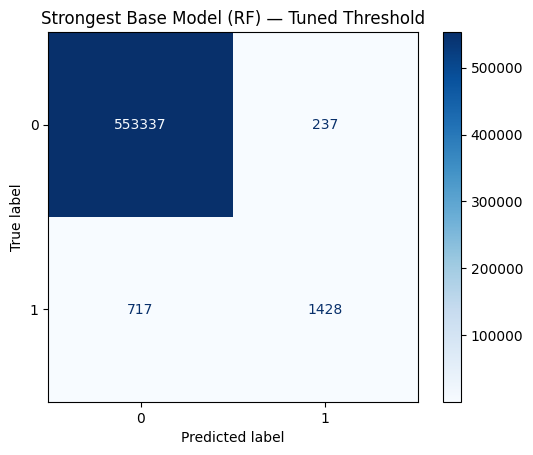

<Figure size 600x500 with 0 Axes>

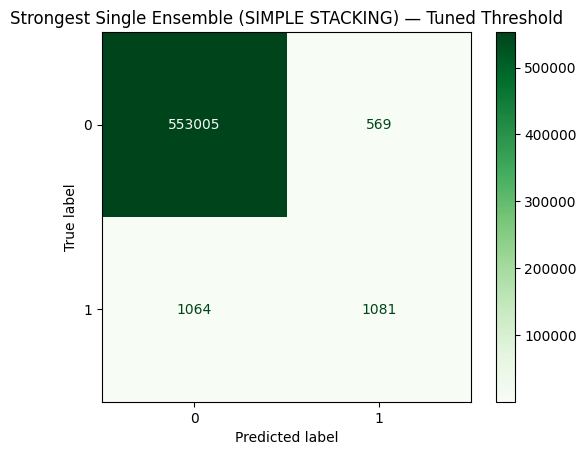

<Figure size 600x500 with 0 Axes>

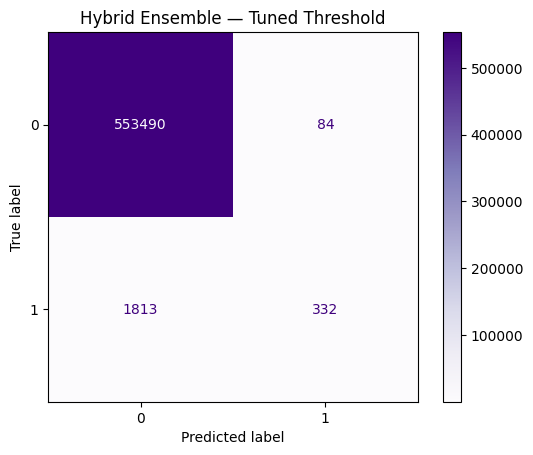

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Confusion Matrix — Strongest Base Model (RF)
cm_base = confusion_matrix(y_test, y_pred_base_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_base)
plt.figure(figsize=(6, 5))
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Strongest Base Model ({best_base_name.upper()}) — Tuned Threshold")
plt.show()
print("\n")

# Confusion Matrix — Strongest Single Ensemble (Simple Stacking)
cm_single = confusion_matrix(y_test, y_pred_single_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_single)
plt.figure(figsize=(6, 5))
disp.plot(cmap="Greens", values_format="d")
plt.title(f"Strongest Single Ensemble ({best_single_name.upper()} STACKING) — Tuned Threshold")
plt.show()
print("\n")

# Confusion Matrix — Hybrid Ensemble
cm_hybrid = confusion_matrix(y_test, y_pred_hybrid_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_hybrid)
plt.figure(figsize=(6, 5))
disp.plot(cmap="Purples", values_format="d")
plt.title("Hybrid Ensemble — Tuned Threshold")
plt.show()
print("\n")

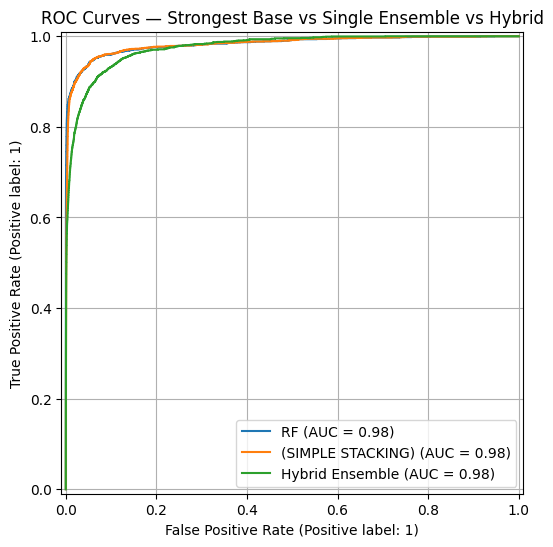

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

# Identify strongest single ensemble
ensemble_dict = {
    "simple": metrics_simple,
    "oof": metrics_oof,
    "blend": metrics_blend
}

best_single_name = max(ensemble_dict, key=ensemble_dict.get)
best_single_pred = {
    "simple": p_simple_test,
    "oof": p_oof_test,
    "blend": p_blend_test
}[best_single_name]

# Plot ROC Curves
plt.figure(figsize=(8,6))
ax = plt.gca()

# Strongest base model (RF)
RocCurveDisplay.from_predictions(
    y_test, best_base_pred,
    name=f"{best_base_name.upper()}",
    ax=ax
)
# Strongest single ensemble (Simple Stacking)
RocCurveDisplay.from_predictions(
    y_test, best_single_pred,
    name=f"{best_single_name.upper()} STACKING",
    ax=ax
)
# Hybrid ensemble
RocCurveDisplay.from_predictions(
    y_test, p_final_test,
    name="Hybrid Ensemble",
    ax=ax
)

plt.title("ROC Curves — Strongest Base vs Single Ensemble vs Hybrid")
plt.grid(True)
plt.show()

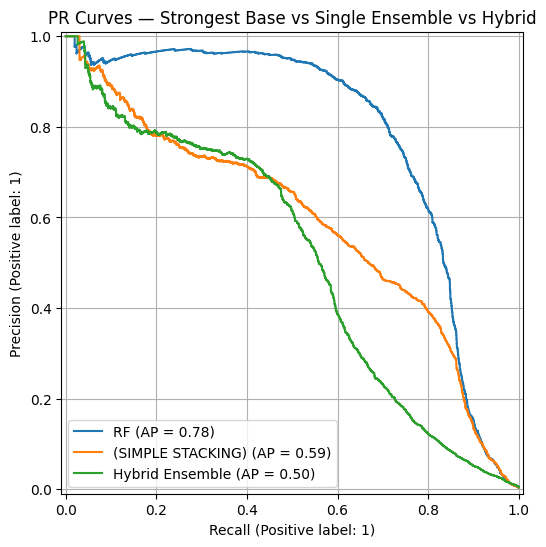

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay

# Plot PR Curves
plt.figure(figsize=(8,6))
ax = plt.gca()

# Strongest base model (RF)
PrecisionRecallDisplay.from_predictions(
    y_test, best_base_pred,
    name=f"{best_base_name.upper()}",
    ax=ax
)
# Strongest single ensemble (Simple Stacking)
PrecisionRecallDisplay.from_predictions(
    y_test, best_single_pred,
    name=f"{best_single_name.upper()} STACKING",
    ax=ax
)
# Hybrid Ensemble
PrecisionRecallDisplay.from_predictions(
    y_test, p_final_test,
    name="Hybrid Ensemble",
    ax=ax
)

plt.title("PR Curves — Strongest Base vs Single Ensemble vs Hybrid")
plt.grid(True)
plt.show()

### Final Evaluation Metrics

In [43]:
# Metric Computation
precision_base_tuned, recall_base_tuned, f1_base_tuned, _ = precision_recall_fscore_support(
    y_test, y_pred_base_tuned, average="binary", zero_division=0
)

precision_single_tuned, recall_single_tuned, f1_single_tuned, _ = precision_recall_fscore_support(
    y_test, y_pred_single_tuned, average="binary", zero_division=0
)

precision_hybrid_tuned, recall_hybrid_tuned, f1_hybrid_tuned, _ = precision_recall_fscore_support(
    y_test, y_pred_hybrid_tuned, average="binary", zero_division=0
)
roc_auc_rf = roc_auc_score(y_test, best_base_pred)
roc_auc_simple = roc_auc_score(y_test, best_single_test_pred)
roc_auc_hybrid = roc_auc_score(y_test, p_final_test)


# Final Evalution Output
print(f"""
===== Random Forest (Final Evaluation — Tuned Threshold) =====

PR-AUC:   {metrics_rf:.6f}
ROC-AUC:  {roc_auc_rf:.6f}
Precision: {precision_base_tuned:.4f}
Recall:    {recall_base_tuned:.4f}
F1:        {f1_base_tuned:.4f}


===== Simple Stacking (Final Evaluation — Tuned Threshold) =====

PR-AUC:   {metrics_simple:.6f}
ROC-AUC:  {roc_auc_simple:.6f}
Precision: {precision_single_tuned:.4f}
Recall:    {recall_single_tuned:.4f}
F1:        {f1_single_tuned:.4f}


===== Hybrid Ensemble (Final Evaluation — Tuned Threshold) =====

PR-AUC:   {metrics_hybrid:.6f}
ROC-AUC:  {roc_auc_hybrid:.6f}
Precision: {precision_hybrid_tuned:.4f}
Recall:    {recall_hybrid_tuned:.4f}
F1:        {f1_hybrid_tuned:.4f}
""")


===== Random Forest (Final Evaluation — Tuned Threshold) =====

PR-AUC:   0.779559
ROC-AUC:  0.983279
Precision: 0.8577
Recall:    0.6657
F1:        0.7496


===== Simple Stacking (Final Evaluation — Tuned Threshold) =====

PR-AUC:   0.585205
ROC-AUC:  0.982560
Precision: 0.6552
Recall:    0.5040
F1:        0.5697


===== Hybrid Ensemble (Final Evaluation — Tuned Threshold) =====

PR-AUC:   0.503488
ROC-AUC:  0.975798
Precision: 0.7981
Recall:    0.1548
F1:        0.2593



### Final Model Selected: Random Forest

- Random Forest was selected as the final model because it consistently outperformed all other models across probabilistic metrics (PR-AUC = 0.7796, ROC-AUC = 0.9833) and threshold-dependent metrics after tuning (Precision = 0.8577, Recall = 0.6657, F1 = 0.7496), even admist extreme class imbalance.
- Ensemble methods (Simple Stacking and Hybrid) underperformed in both probability ranking and threshold-based detection, indicating either overfitting or weaker generalization
- Therefore, Random Forest provides the most reliable and balanced performance for fraud detection in this highly imbalanced dataset.